# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import accuracy_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

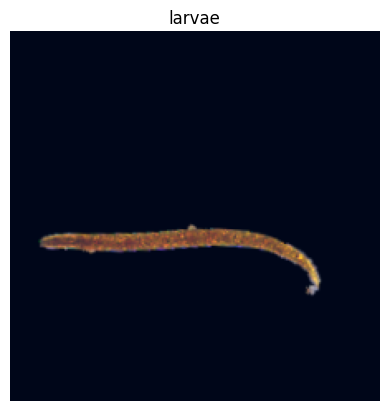

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Linear-13                  [-1, 128]       6,422,656
             ReLU-14                  [

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7789 | Val Loss: 0.6273 | Train cohen_kappa_fn: 0.1246 | Val cohen_kappa_fn: 0.0913 | Train accuracy_fn: 0.4674 | Val accuracy_fn: 0.4656
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6212 | Val Loss: 0.6612 | Train cohen_kappa_fn: 0.1704 | Val cohen_kappa_fn: 0.1788 | Train accuracy_fn: 0.7556 | Val accuracy_fn: 0.8188
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.5565 | Val Loss: 0.5508 | Train cohen_kappa_fn: 0.1890 | Val cohen_kappa_fn: 0.1296 | Train accuracy_fn: 0.5439 | Val accuracy_fn: 0.4938
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4891 | Val Loss: 0.5472 | Train cohen_kappa_fn: 0.3954 | Val cohen_kappa_fn: 0.1903 | Train accuracy_fn: 0.7794 | Val accuracy_fn: 0.5969
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4636 | Val Loss: 0.5558 | Train cohen_kappa_fn: 0.2769 | Val cohen_kappa_fn: 0.1293 | Train accuracy_fn: 0.6378 | Val accuracy_fn: 0.4281
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.4678 | Val Loss: 0.4793 | Train cohen_kappa_fn: 0.5573 | Val cohen_kappa_fn: 0.3813 | Train accuracy_fn: 0.8734 | Val accuracy_fn: 0.7531
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4294 | Val Loss: 0.6142 | Train cohen_kappa_fn: 0.1705 | Val cohen_kappa_fn: 0.1038 | Train accuracy_fn: 0.4925 | Val accuracy_fn: 0.3844
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.4308 | Val Loss: 0.3921 | Train cohen_kappa_fn: 0.5936 | Val cohen_kappa_fn: 0.4688 | Train accuracy_fn: 0.8722 | Val accuracy_fn: 0.7937
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3906 | Val Loss: 0.3336 | Train cohen_kappa_fn: 0.5643 | Val cohen_kappa_fn: 0.5656 | Train accuracy_fn: 0.8471 | Val accuracy_fn: 0.8500
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3576 | Val Loss: 0.4501 | Train cohen_kappa_fn: 0.3705 | Val cohen_kappa_fn: 0.2073 | Train accuracy_fn: 0.7093 | Val accuracy_fn: 0.5406
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3252 | Val Loss: 0.2734 | Train cohen_kappa_fn: 0.6824 | Val cohen_kappa_fn: 0.7330 | Train accuracy_fn: 0.9073 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3222 | Val Loss: 0.2896 | Train cohen_kappa_fn: 0.6900 | Val cohen_kappa_fn: 0.7330 | Train accuracy_fn: 0.9135 | Val accuracy_fn: 0.9250
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2874 | Val Loss: 0.2731 | Train cohen_kappa_fn: 0.6824 | Val cohen_kappa_fn: 0.5875 | Train accuracy_fn: 0.8960 | Val accuracy_fn: 0.8531
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2813 | Val Loss: 0.2885 | Train cohen_kappa_fn: 0.6131 | Val cohen_kappa_fn: 0.5012 | Train accuracy_fn: 0.8659 | Val accuracy_fn: 0.8031
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2590 | Val Loss: 0.2313 | Train cohen_kappa_fn: 0.7654 | Val cohen_kappa_fn: 0.7740 | Train accuracy_fn: 0.9323 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2387 | Val Loss: 0.2292 | Train cohen_kappa_fn: 0.7525 | Val cohen_kappa_fn: 0.7370 | Train accuracy_fn: 0.9273 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2257 | Val Loss: 0.2901 | Train cohen_kappa_fn: 0.6241 | Val cohen_kappa_fn: 0.4909 | Train accuracy_fn: 0.8684 | Val accuracy_fn: 0.7969
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1943 | Val Loss: 0.2929 | Train cohen_kappa_fn: 0.5568 | Val cohen_kappa_fn: 0.4519 | Train accuracy_fn: 0.8333 | Val accuracy_fn: 0.7719
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2134 | Val Loss: 0.2190 | Train cohen_kappa_fn: 0.7745 | Val cohen_kappa_fn: 0.7330 | Train accuracy_fn: 0.9336 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1897 | Val Loss: 0.2678 | Train cohen_kappa_fn: 0.7474 | Val cohen_kappa_fn: 0.5638 | Train accuracy_fn: 0.9223 | Val accuracy_fn: 0.8438
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1774 | Val Loss: 0.2278 | Train cohen_kappa_fn: 0.6625 | Val cohen_kappa_fn: 0.6313 | Train accuracy_fn: 0.8860 | Val accuracy_fn: 0.8719
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1569 | Val Loss: 0.2025 | Train cohen_kappa_fn: 0.7392 | Val cohen_kappa_fn: 0.7434 | Train accuracy_fn: 0.9198 | Val accuracy_fn: 0.9219
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1609 | Val Loss: 0.2528 | Train cohen_kappa_fn: 0.8170 | Val cohen_kappa_fn: 0.7186 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9125
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1801 | Val Loss: 0.2115 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.7645 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9344
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1807 | Val Loss: 0.2737 | Train cohen_kappa_fn: 0.8081 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9511 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1336 | Val Loss: 0.2050 | Train cohen_kappa_fn: 0.7225 | Val cohen_kappa_fn: 0.7105 | Train accuracy_fn: 0.9110 | Val accuracy_fn: 0.9062
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1496 | Val Loss: 0.2062 | Train cohen_kappa_fn: 0.8311 | Val cohen_kappa_fn: 0.7740 | Train accuracy_fn: 0.9511 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


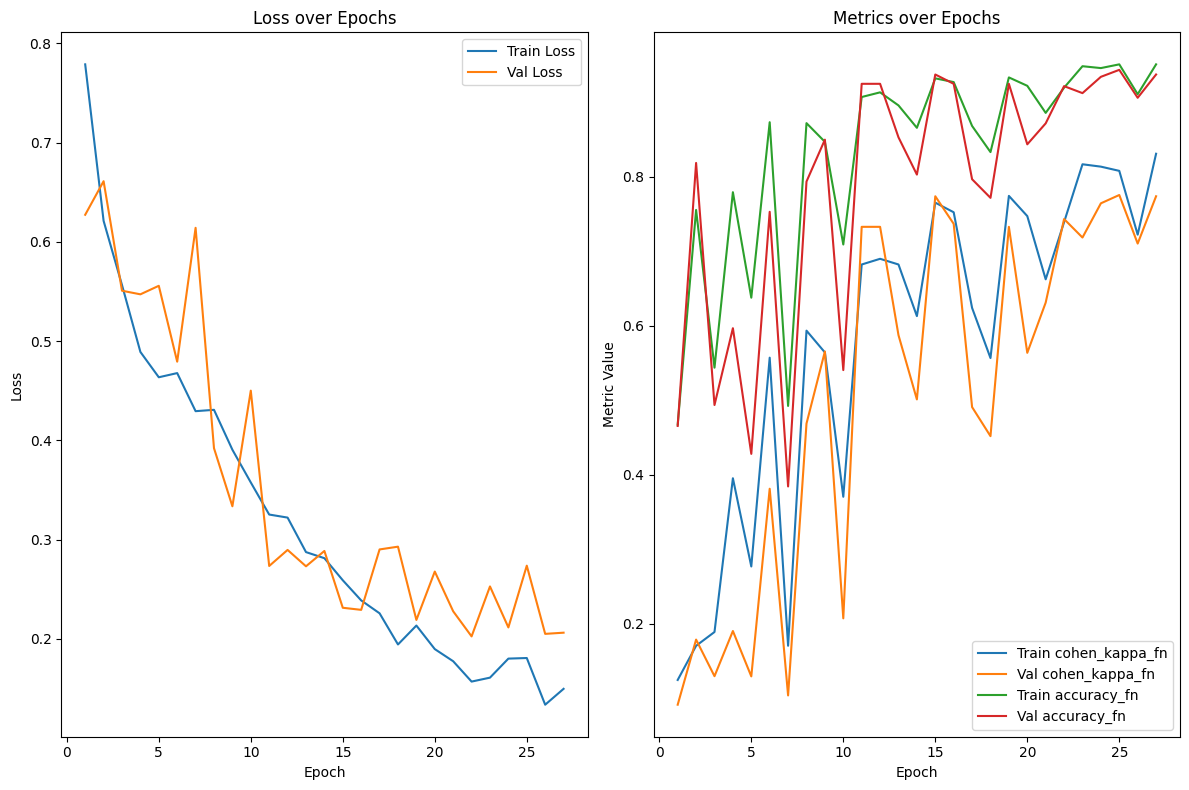

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1932 | Test cohen_kappa_fn: 0.7519 | Test accuracy_fn: 0.9271


#### Visualization

In [14]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

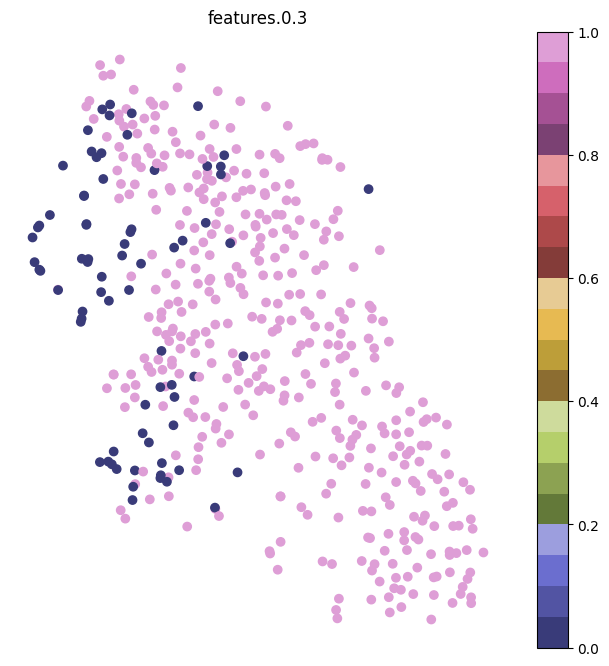

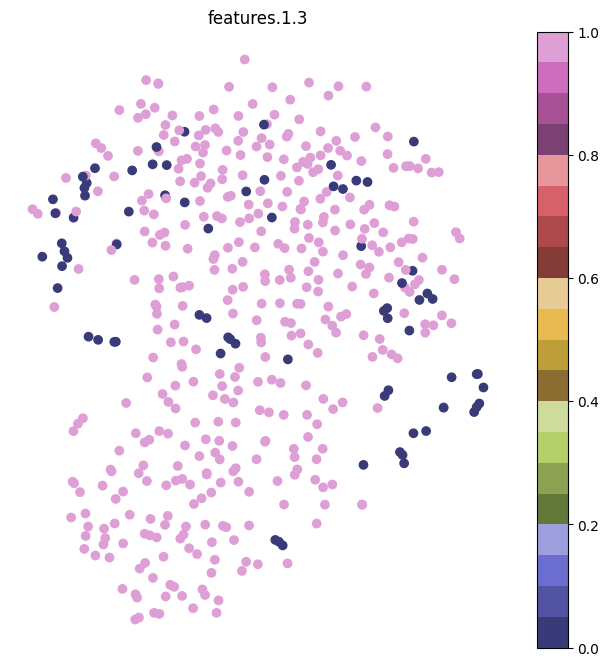

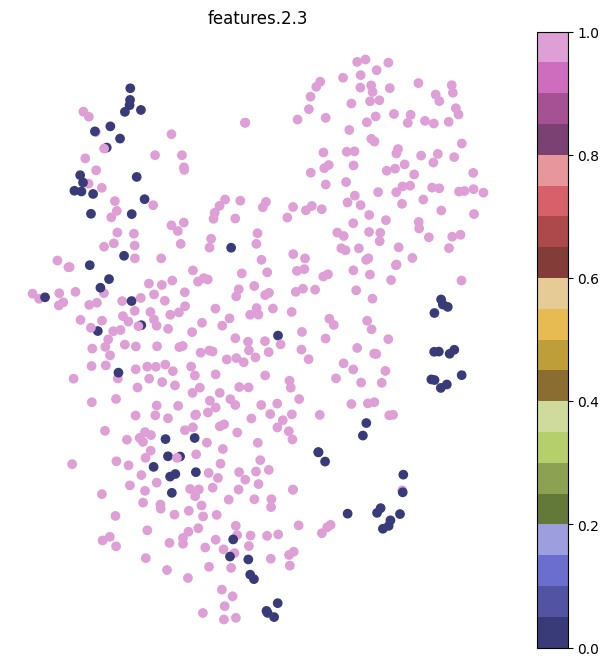

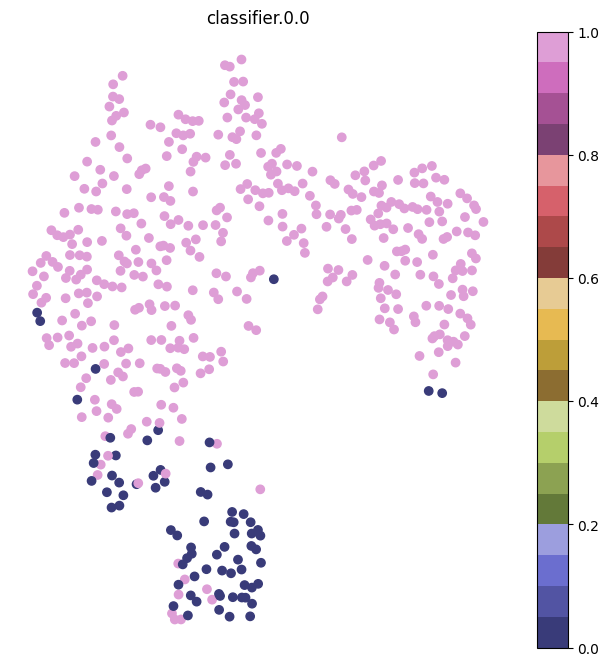

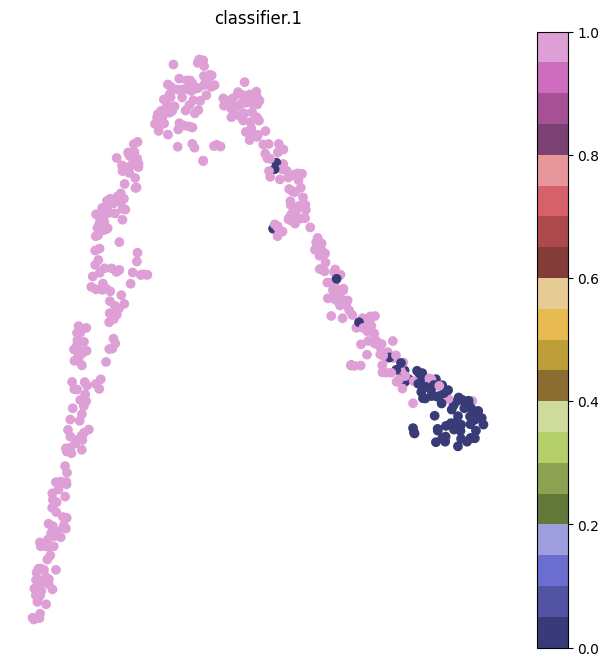

In [15]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


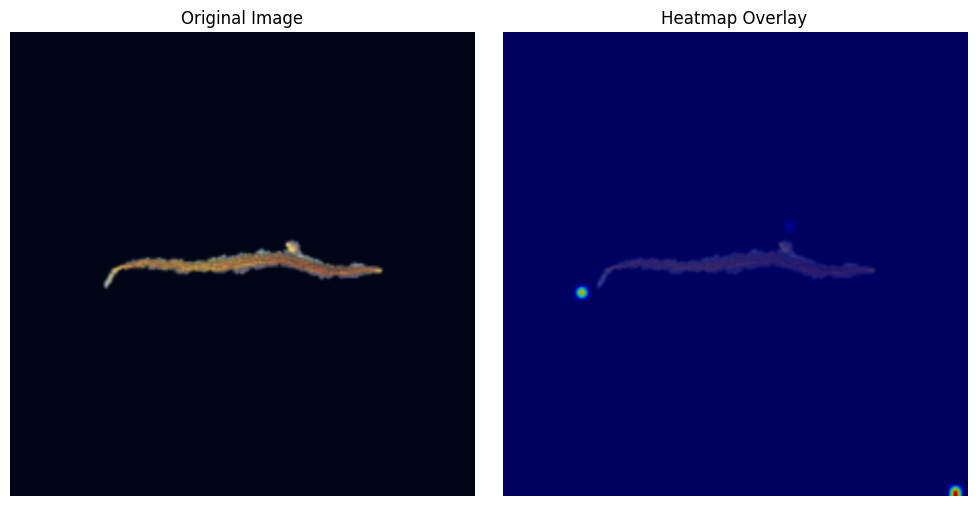

  Generating heatmap for Larvae...
  Predicted label is Larvae!


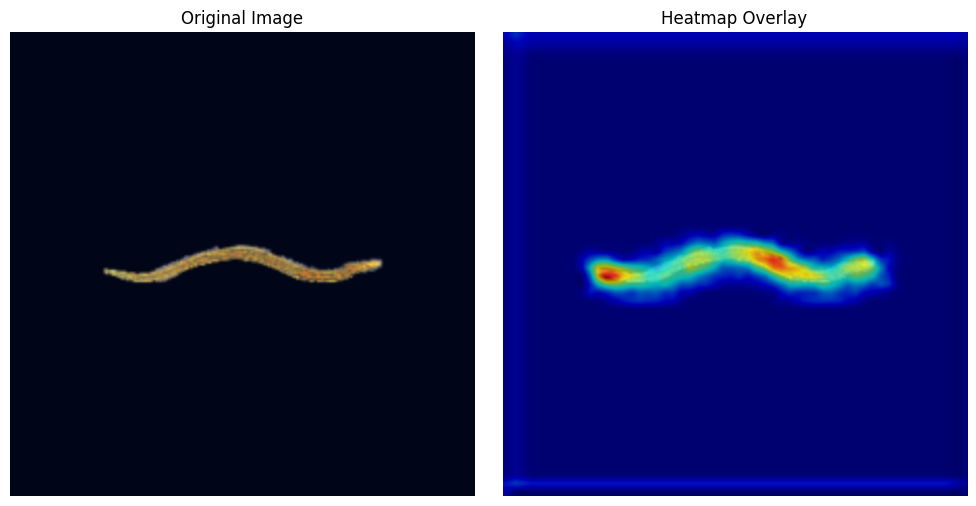

In [16]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [17]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [18]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [19]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7909 | Val Loss: 0.6832 | Train cohen_kappa_fn: 0.0209 | Val cohen_kappa_fn: 0.0376 | Train accuracy_fn: 0.2143 | Val accuracy_fn: 0.2500
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6658 | Val Loss: 0.6309 | Train cohen_kappa_fn: 0.1303 | Val cohen_kappa_fn: 0.1099 | Train accuracy_fn: 0.4837 | Val accuracy_fn: 0.4938
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6086 | Val Loss: 0.5365 | Train cohen_kappa_fn: 0.2481 | Val cohen_kappa_fn: 0.3182 | Train accuracy_fn: 0.6078 | Val accuracy_fn: 0.6781
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5156 | Val Loss: 0.4770 | Train cohen_kappa_fn: 0.2157 | Val cohen_kappa_fn: 0.2048 | Train accuracy_fn: 0.5589 | Val accuracy_fn: 0.5375
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4325 | Val Loss: 0.3646 | Train cohen_kappa_fn: 0.4782 | Val cohen_kappa_fn: 0.4854 | Train accuracy_fn: 0.7970 | Val accuracy_fn: 0.7969
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3320 | Val Loss: 0.2737 | Train cohen_kappa_fn: 0.6751 | Val cohen_kappa_fn: 0.6240 | Train accuracy_fn: 0.8972 | Val accuracy_fn: 0.8750
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2923 | Val Loss: 0.2952 | Train cohen_kappa_fn: 0.5062 | Val cohen_kappa_fn: 0.4863 | Train accuracy_fn: 0.8058 | Val accuracy_fn: 0.7906
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2718 | Val Loss: 0.6022 | Train cohen_kappa_fn: 0.2185 | Val cohen_kappa_fn: 0.1680 | Train accuracy_fn: 0.5564 | Val accuracy_fn: 0.4875
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2558 | Val Loss: 0.4228 | Train cohen_kappa_fn: 0.8258 | Val cohen_kappa_fn: 0.7592 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2382 | Val Loss: 0.1960 | Train cohen_kappa_fn: 0.7542 | Val cohen_kappa_fn: 0.7064 | Train accuracy_fn: 0.9248 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1874 | Val Loss: 0.3066 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.7692 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1821 | Val Loss: 0.2243 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.7681 | Train accuracy_fn: 0.9511 | Val accuracy_fn: 0.9344
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1562 | Val Loss: 0.5147 | Train cohen_kappa_fn: 0.8598 | Val cohen_kappa_fn: 0.6534 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9250
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1548 | Val Loss: 0.2436 | Train cohen_kappa_fn: 0.8321 | Val cohen_kappa_fn: 0.7902 | Train accuracy_fn: 0.9511 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1327 | Val Loss: 0.3019 | Train cohen_kappa_fn: 0.4192 | Val cohen_kappa_fn: 0.4859 | Train accuracy_fn: 0.7469 | Val accuracy_fn: 0.7937
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


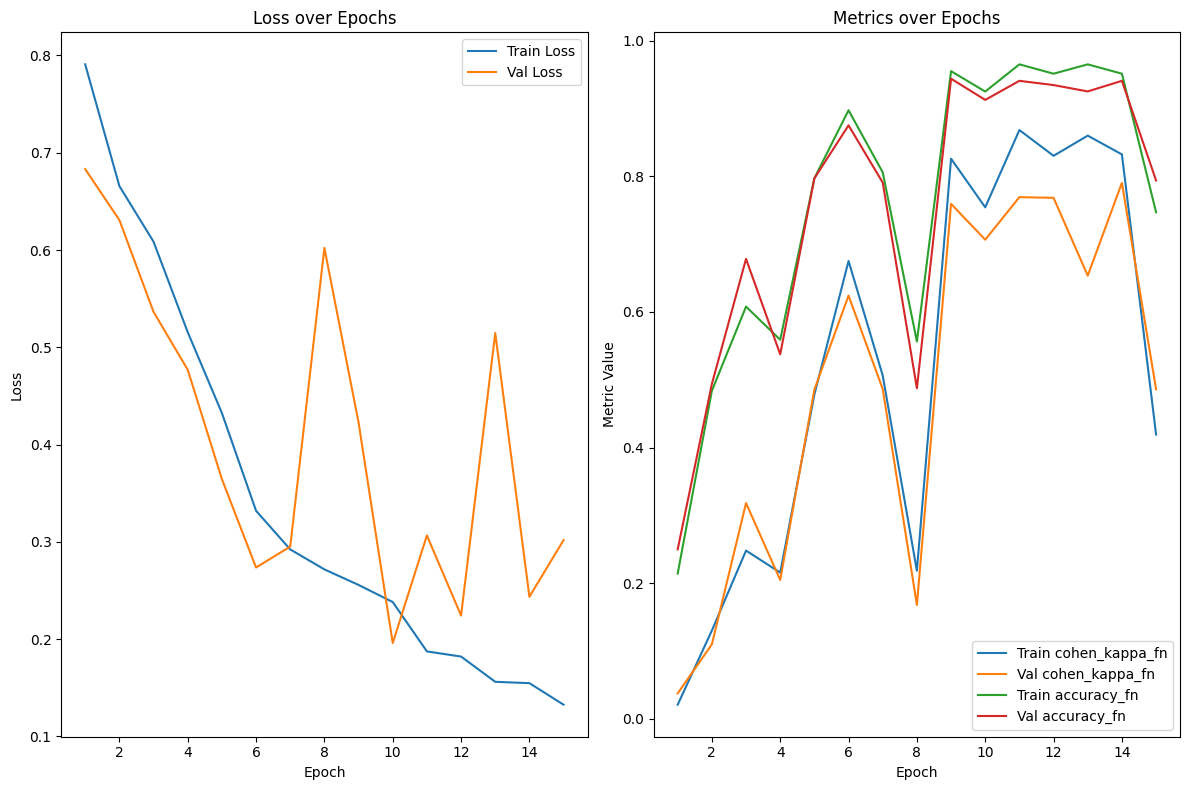

In [20]:
trainer_cnn_1.plot_epochs()

In [21]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1845 | Test cohen_kappa_fn: 0.7924 | Test accuracy_fn: 0.9417


#### Visualization

In [22]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

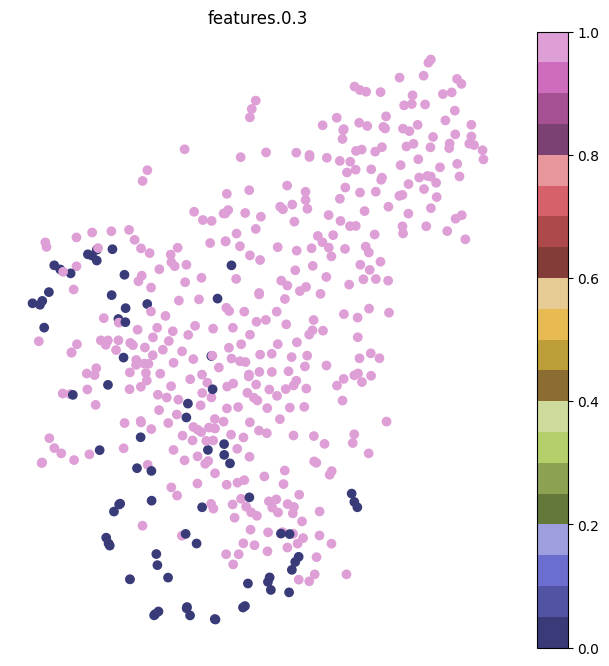

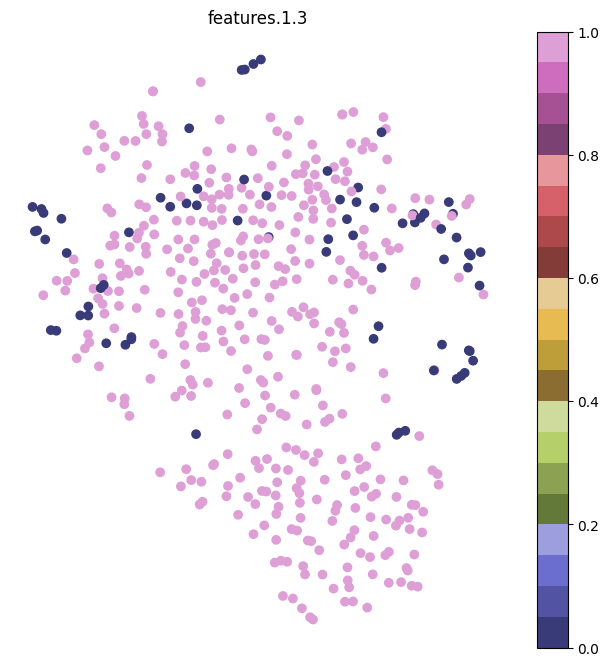

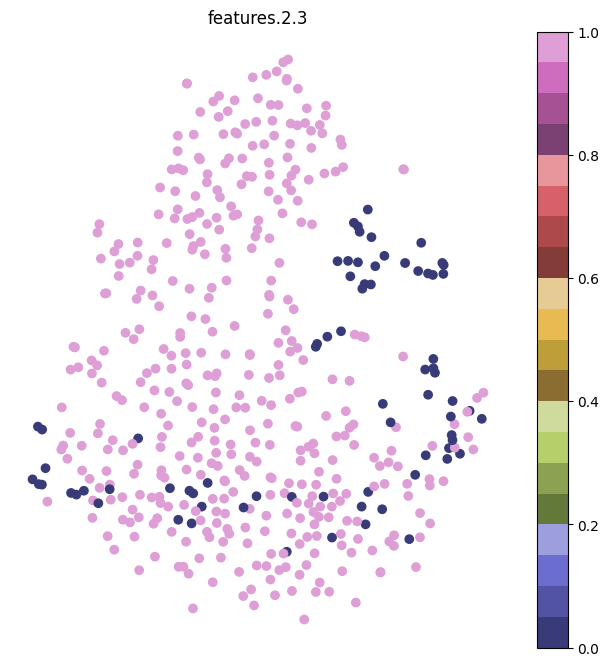

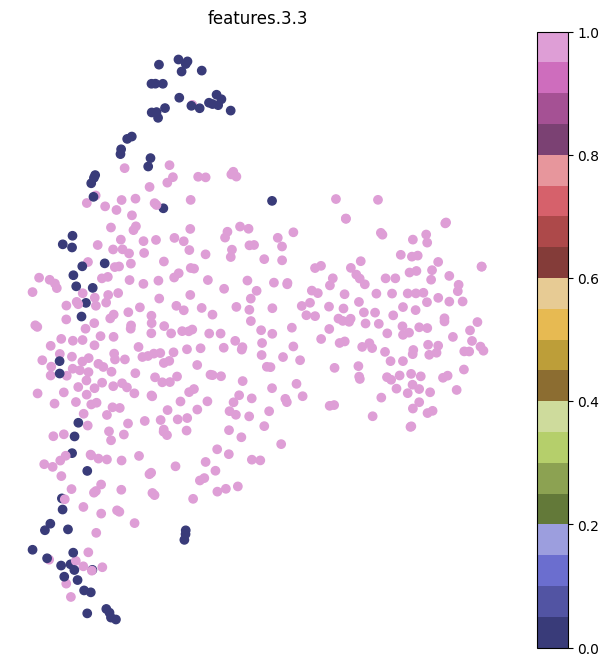

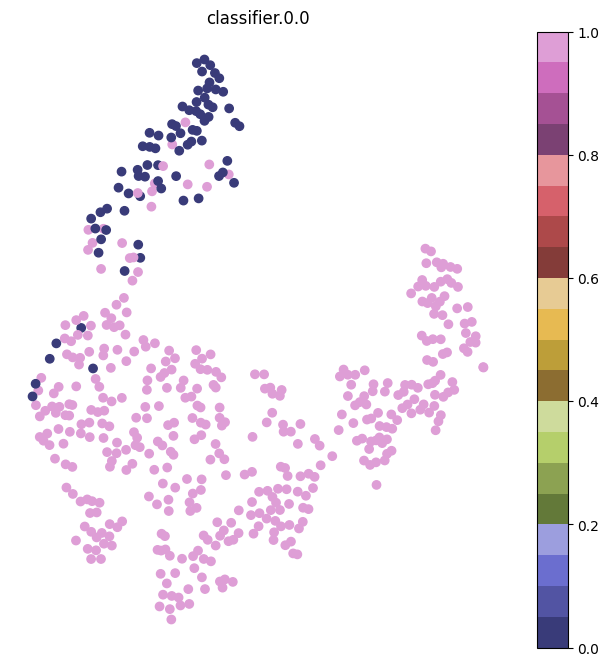

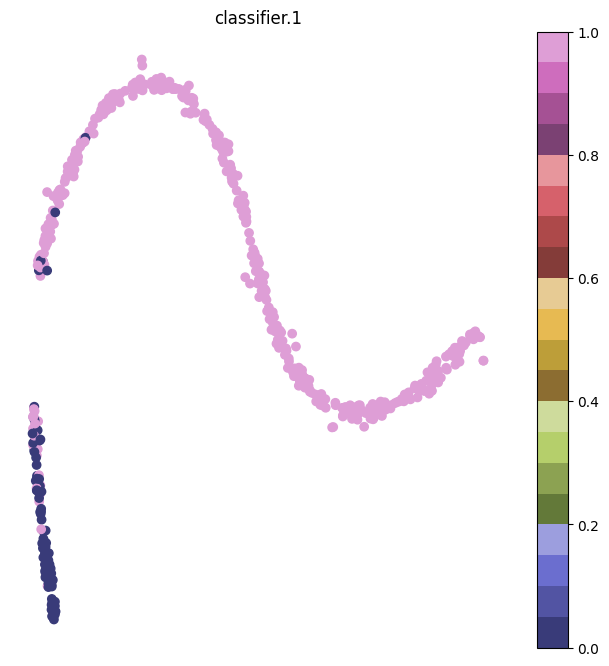

In [23]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


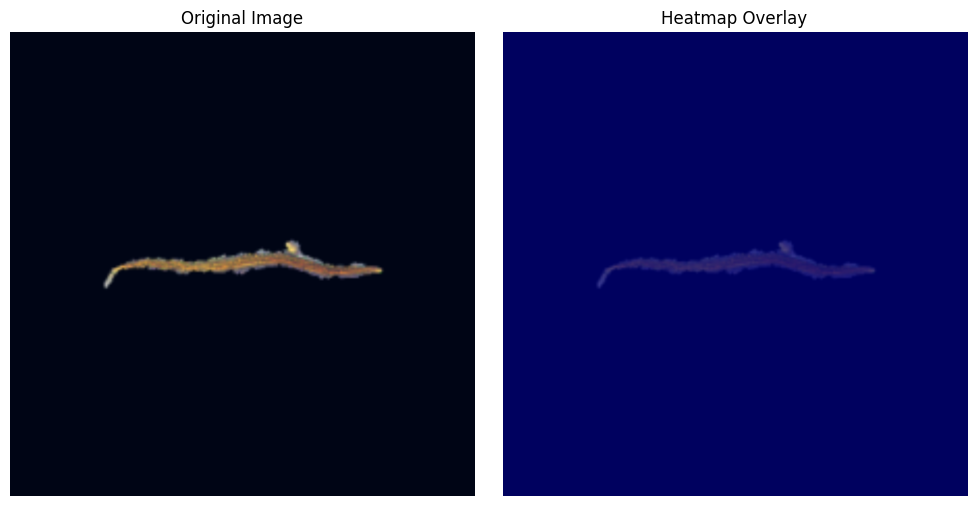

  Generating heatmap for Larvae...
  Predicted label is Larvae!


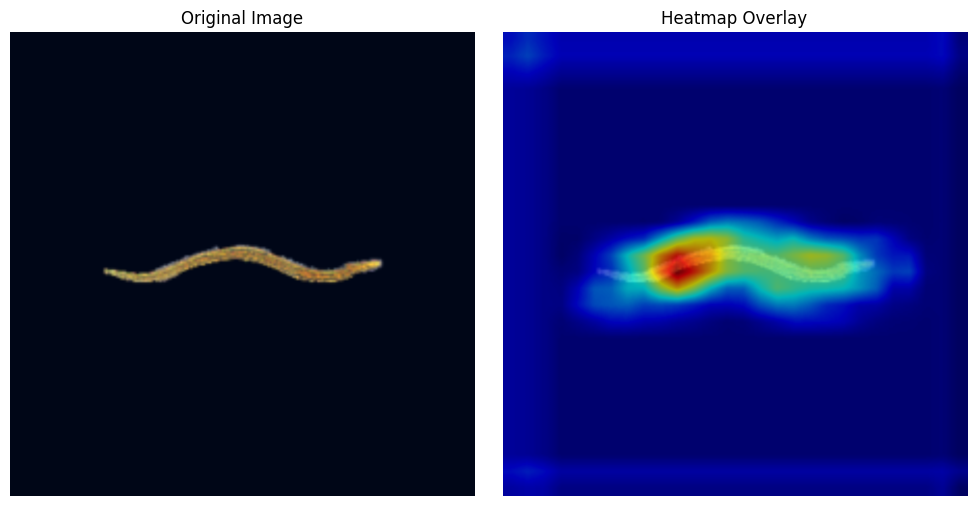

In [24]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [25]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [26]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [27]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6263 | Val Loss: 0.5043 | Train cohen_kappa_fn: 0.3261 | Val cohen_kappa_fn: 0.3399 | Train accuracy_fn: 0.7168 | Val accuracy_fn: 0.6969
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4566 | Val Loss: 0.3281 | Train cohen_kappa_fn: 0.5868 | Val cohen_kappa_fn: 0.5230 | Train accuracy_fn: 0.8622 | Val accuracy_fn: 0.8281
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.3422 | Val Loss: 0.8368 | Train cohen_kappa_fn: 0.1422 | Val cohen_kappa_fn: 0.0820 | Train accuracy_fn: 0.4499 | Val accuracy_fn: 0.3438
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.3465 | Val Loss: 0.4028 | Train cohen_kappa_fn: 0.4938 | Val cohen_kappa_fn: 0.3469 | Train accuracy_fn: 0.7982 | Val accuracy_fn: 0.6875
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2402 | Val Loss: 0.2284 | Train cohen_kappa_fn: 0.8326 | Val cohen_kappa_fn: 0.7239 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9219
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3053 | Val Loss: 0.2421 | Train cohen_kappa_fn: 0.8654 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1921 | Val Loss: 0.3207 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.8115 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1694 | Val Loss: 0.2254 | Train cohen_kappa_fn: 0.8657 | Val cohen_kappa_fn: 0.7966 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1546 | Val Loss: 0.3812 | Train cohen_kappa_fn: 0.8139 | Val cohen_kappa_fn: 0.7826 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1508 | Val Loss: 0.3126 | Train cohen_kappa_fn: 0.5021 | Val cohen_kappa_fn: 0.5172 | Train accuracy_fn: 0.8033 | Val accuracy_fn: 0.8219
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1316 | Val Loss: 0.3404 | Train cohen_kappa_fn: 0.8569 | Val cohen_kappa_fn: 0.8082 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.0998 | Val Loss: 0.2386 | Train cohen_kappa_fn: 0.9117 | Val cohen_kappa_fn: 0.8641 | Train accuracy_fn: 0.9774 | Val accuracy_fn: 0.9656
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1155 | Val Loss: 0.2389 | Train cohen_kappa_fn: 0.7023 | Val cohen_kappa_fn: 0.6199 | Train accuracy_fn: 0.9023 | Val accuracy_fn: 0.8687
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


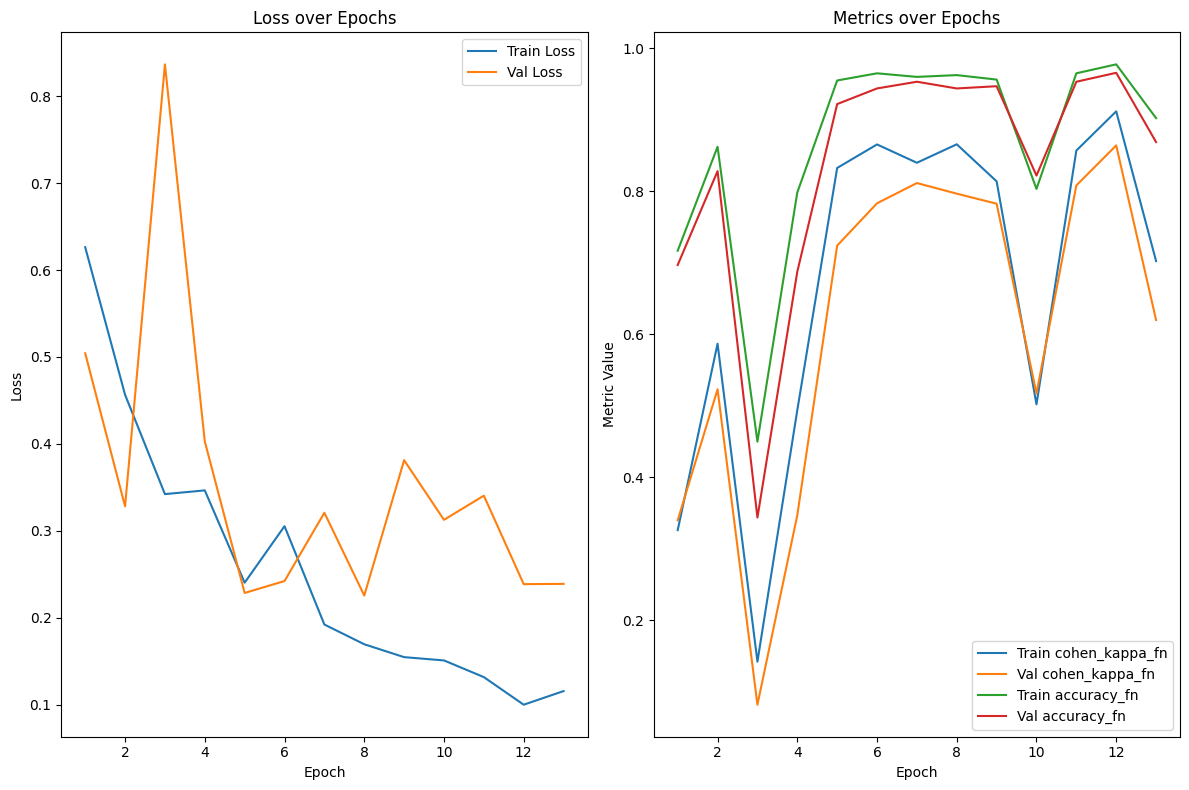

In [28]:
trainer_cnn_2.plot_epochs()

In [29]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1852 | Test cohen_kappa_fn: 0.8491 | Test accuracy_fn: 0.9604


#### Visualization

In [30]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

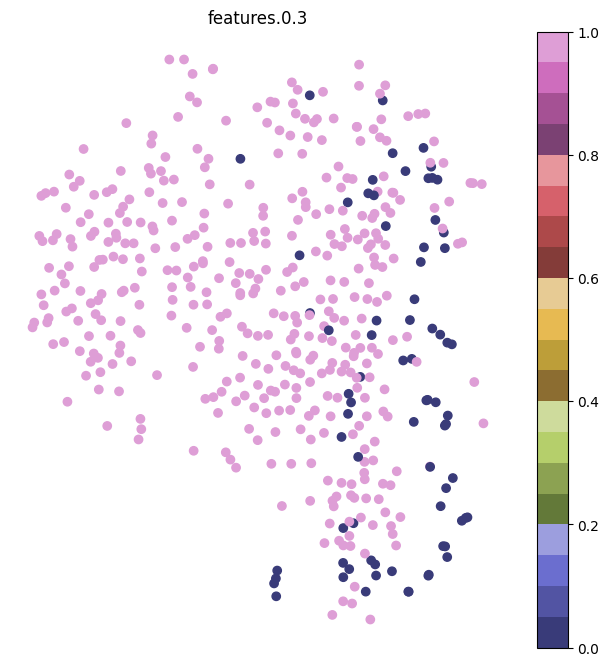

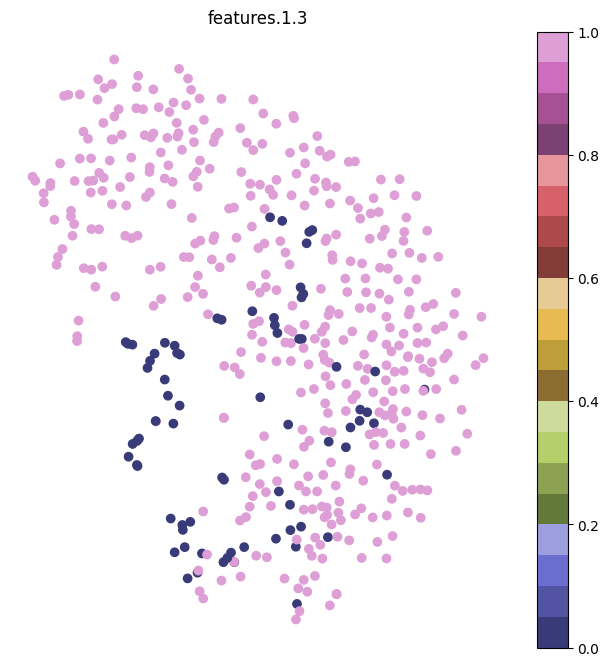

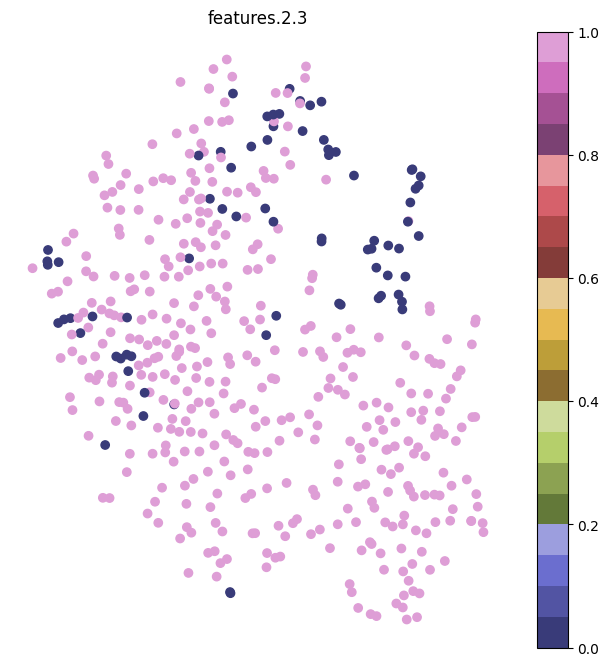

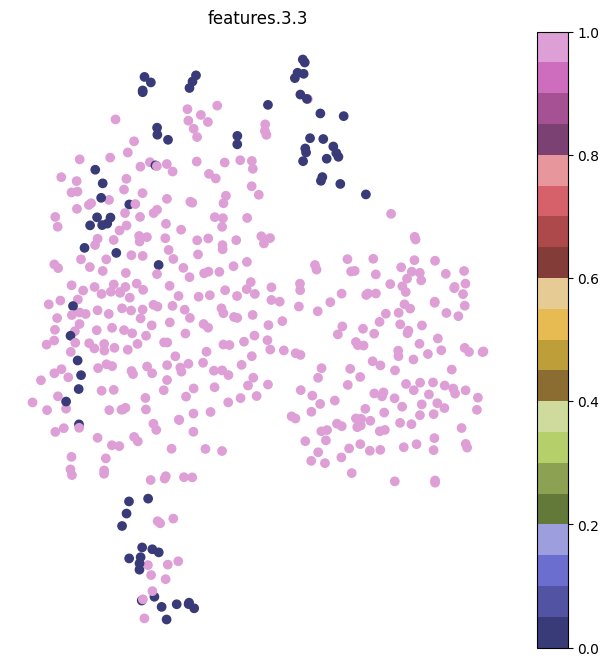

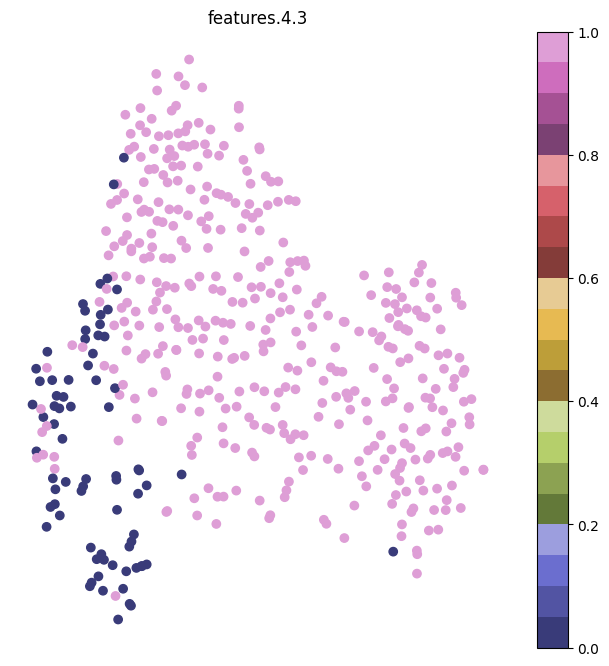

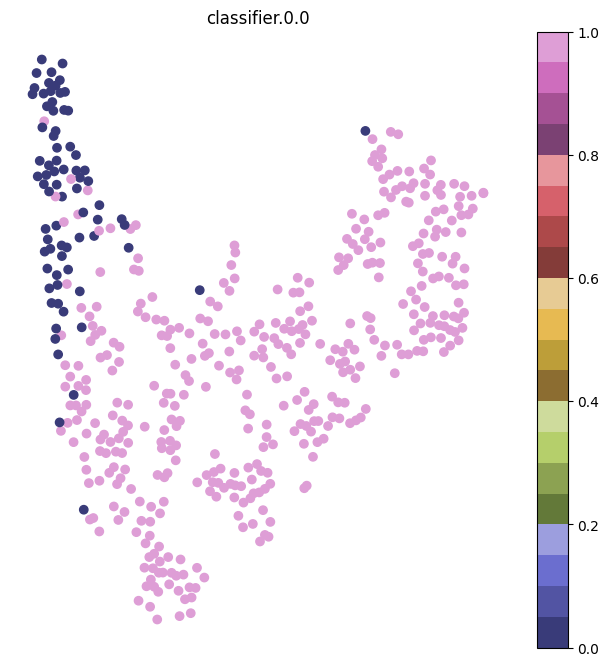

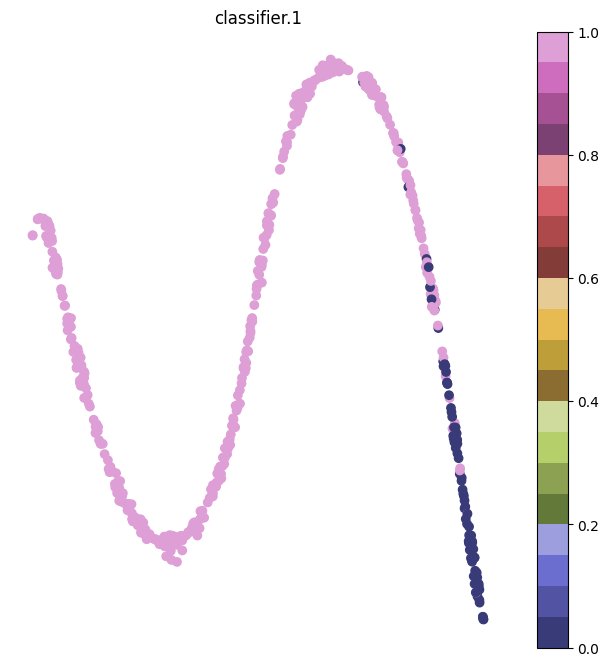

In [31]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


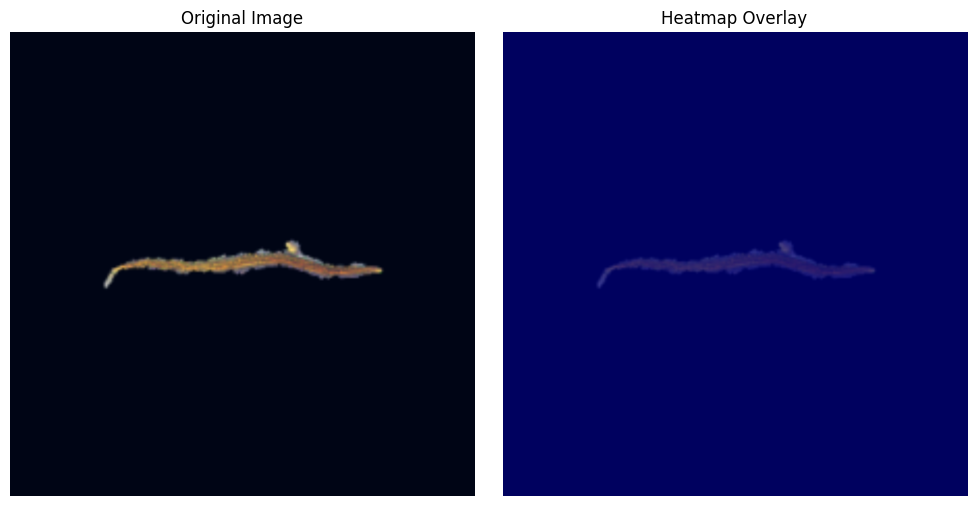

  Generating heatmap for Larvae...
  Predicted label is Larvae!


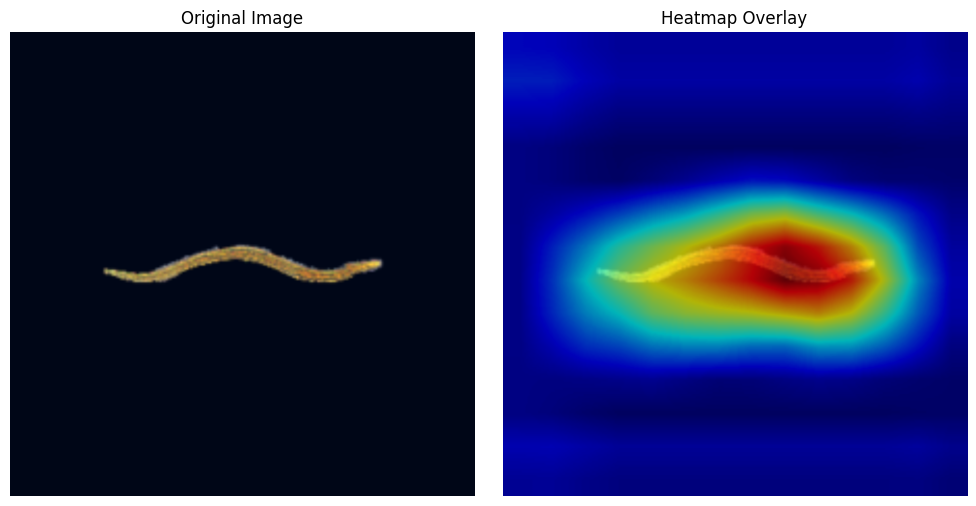

In [32]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [33]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256,512],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [34]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=3e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [35]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6971 | Val Loss: 0.6145 | Train cohen_kappa_fn: 0.2244 | Val cohen_kappa_fn: 0.1988 | Train accuracy_fn: 0.6855 | Val accuracy_fn: 0.6906
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5051 | Val Loss: 0.5536 | Train cohen_kappa_fn: 0.2468 | Val cohen_kappa_fn: 0.1724 | Train accuracy_fn: 0.5927 | Val accuracy_fn: 0.4938
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.3278 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7914 | Val cohen_kappa_fn: 0.6977 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2583 | Val Loss: 0.2768 | Train cohen_kappa_fn: 0.8345 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2542 | Val Loss: 1.4524 | Train cohen_kappa_fn: 0.0255 | Val cohen_kappa_fn: 0.0243 | Train accuracy_fn: 0.2256 | Val accuracy_fn: 0.2313
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.2097 | Val Loss: 0.2773 | Train cohen_kappa_fn: 0.8187 | Val cohen_kappa_fn: 0.8104 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1499 | Val Loss: 1.2945 | Train cohen_kappa_fn: 0.4810 | Val cohen_kappa_fn: 0.3962 | Train accuracy_fn: 0.8997 | Val accuracy_fn: 0.8875
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1704 | Val Loss: 0.2208 | Train cohen_kappa_fn: 0.8780 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9500
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1740 | Val Loss: 0.6704 | Train cohen_kappa_fn: 0.1857 | Val cohen_kappa_fn: 0.2780 | Train accuracy_fn: 0.5138 | Val accuracy_fn: 0.6281
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1200 | Val Loss: 0.3369 | Train cohen_kappa_fn: 0.8699 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.0961 | Val Loss: 0.1599 | Train cohen_kappa_fn: 0.8884 | Val cohen_kappa_fn: 0.8472 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9594
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1250 | Val Loss: 0.3941 | Train cohen_kappa_fn: 0.3368 | Val cohen_kappa_fn: 0.5062 | Train accuracy_fn: 0.6805 | Val accuracy_fn: 0.8125
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1057 | Val Loss: 0.1798 | Train cohen_kappa_fn: 0.7834 | Val cohen_kappa_fn: 0.7065 | Train accuracy_fn: 0.9336 | Val accuracy_fn: 0.9094
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.0955 | Val Loss: 0.5413 | Train cohen_kappa_fn: 0.8652 | Val cohen_kappa_fn: 0.7168 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1219 | Val Loss: 0.2054 | Train cohen_kappa_fn: 0.4981 | Val cohen_kappa_fn: 0.6870 | Train accuracy_fn: 0.7995 | Val accuracy_fn: 0.9000
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0822 | Val Loss: 0.6245 | Train cohen_kappa_fn: 0.8339 | Val cohen_kappa_fn: 0.7500 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


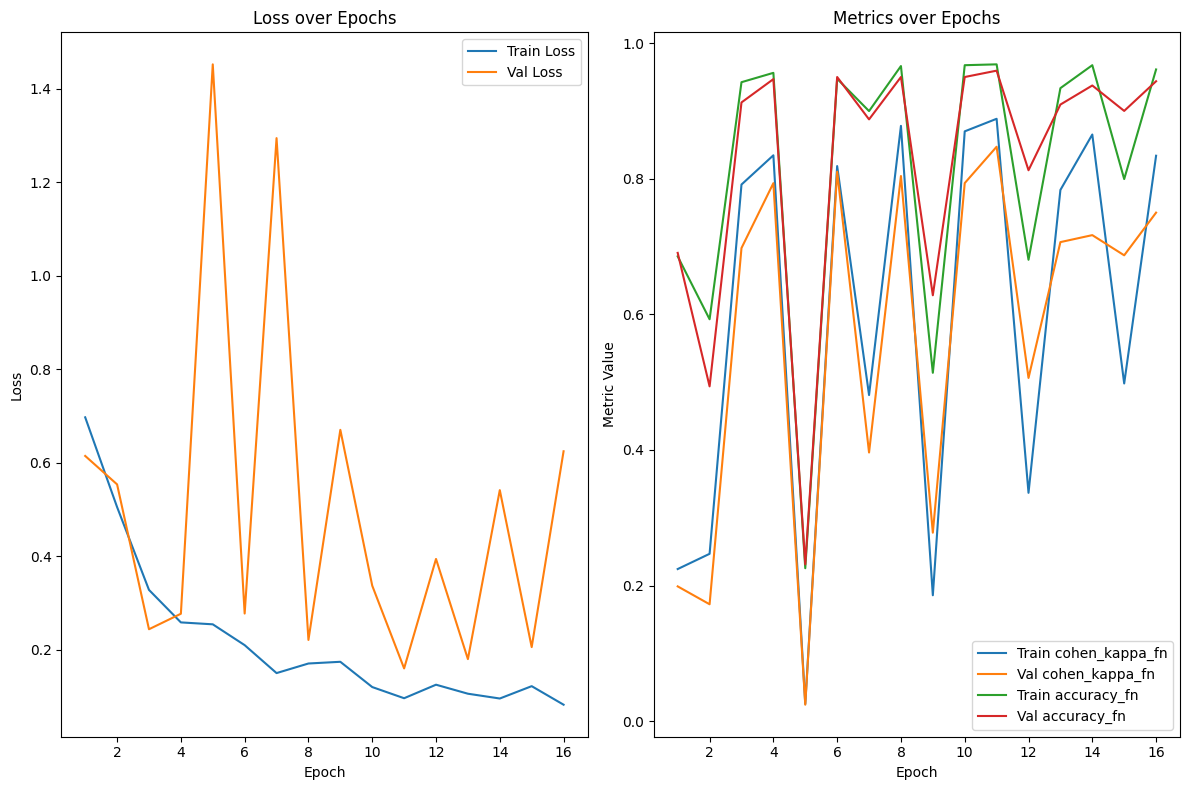

In [36]:
trainer_cnn_3.plot_epochs()

In [37]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2175 | Test cohen_kappa_fn: 0.8546 | Test accuracy_fn: 0.9625


#### Visualization

In [38]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

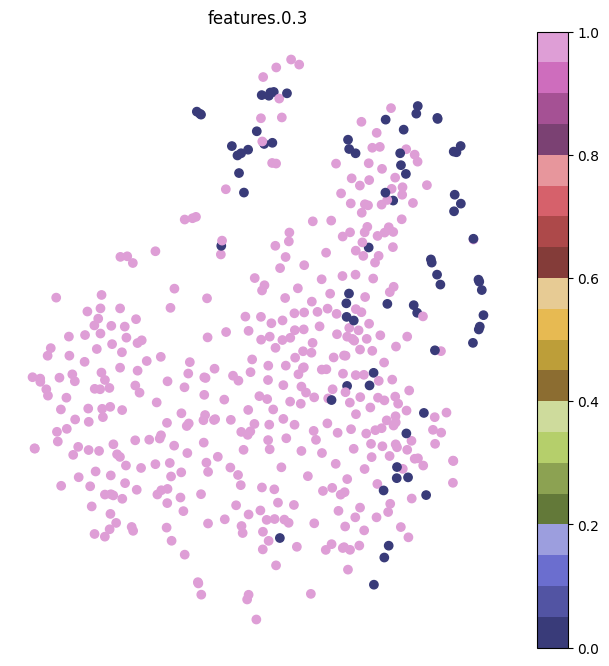

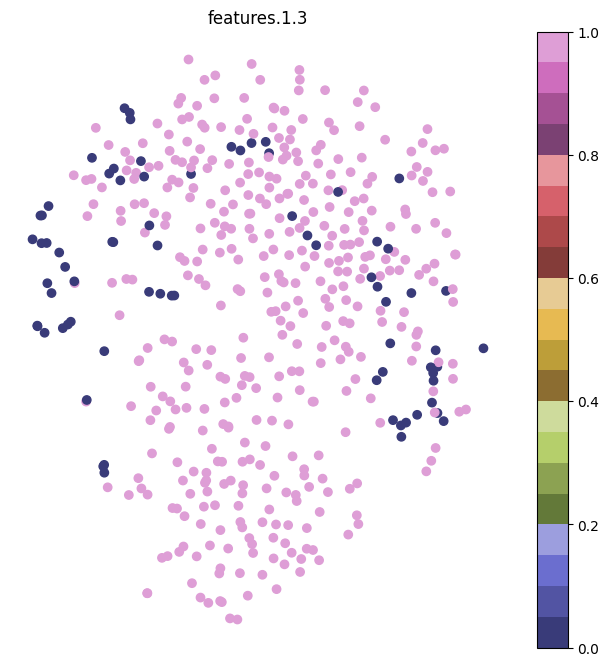

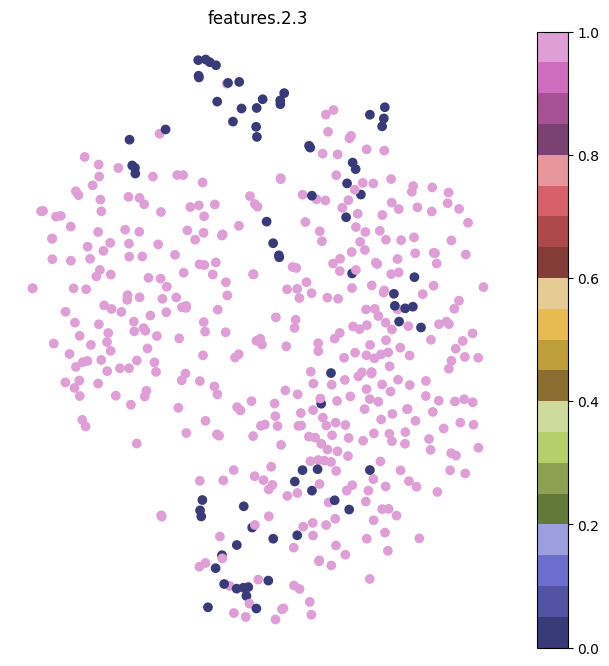

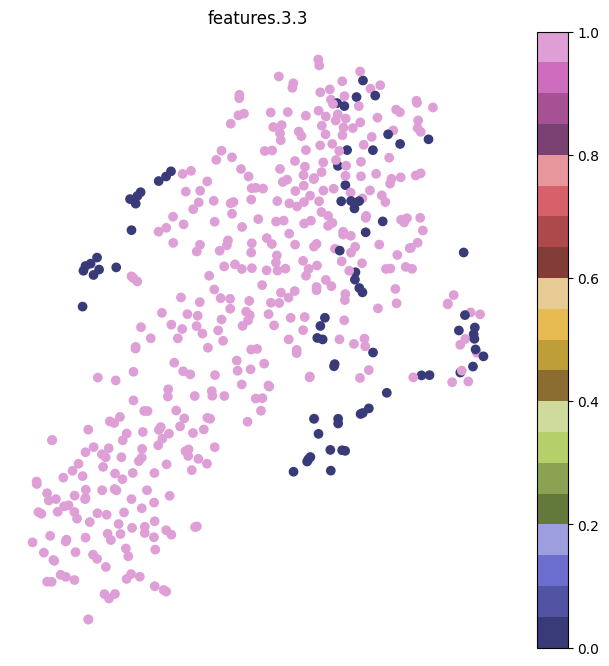

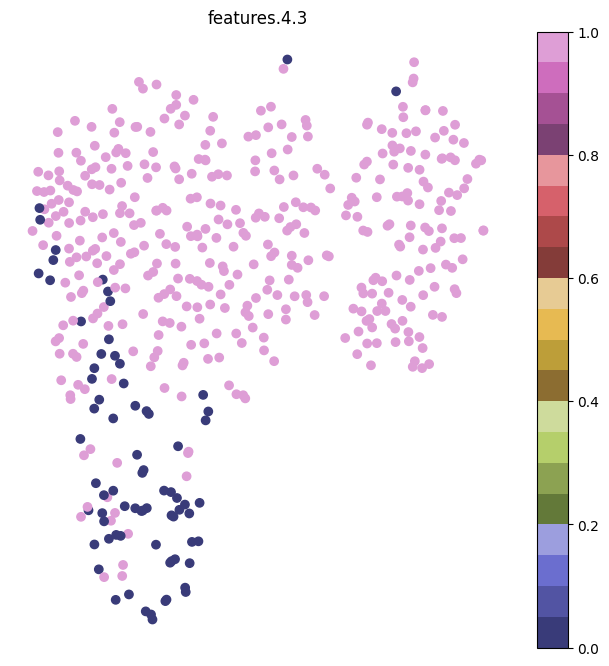

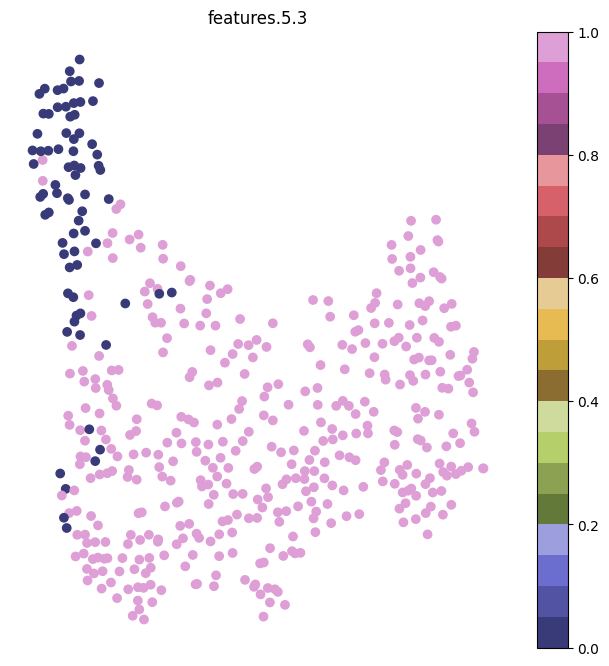

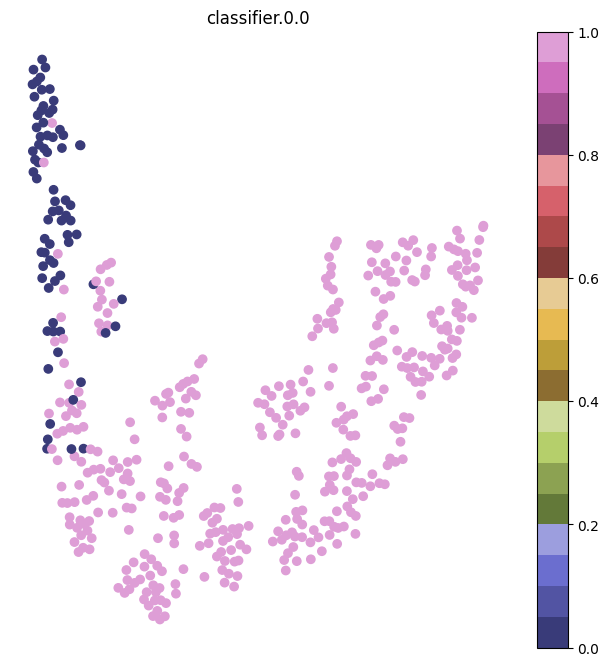

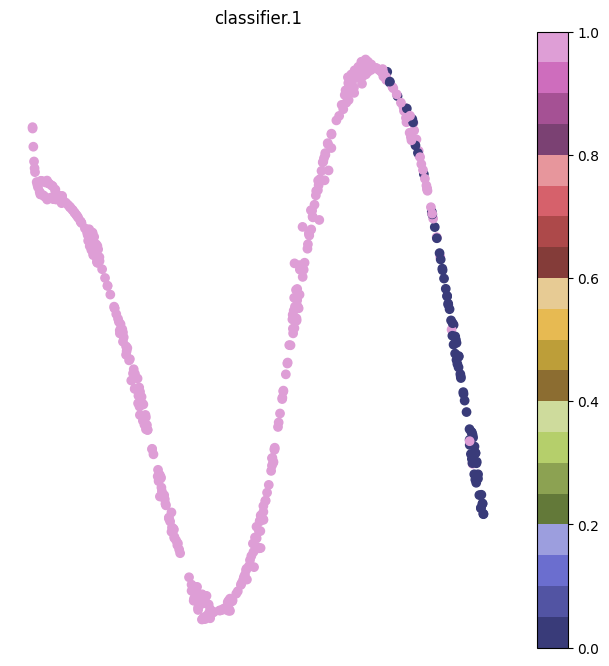

In [39]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


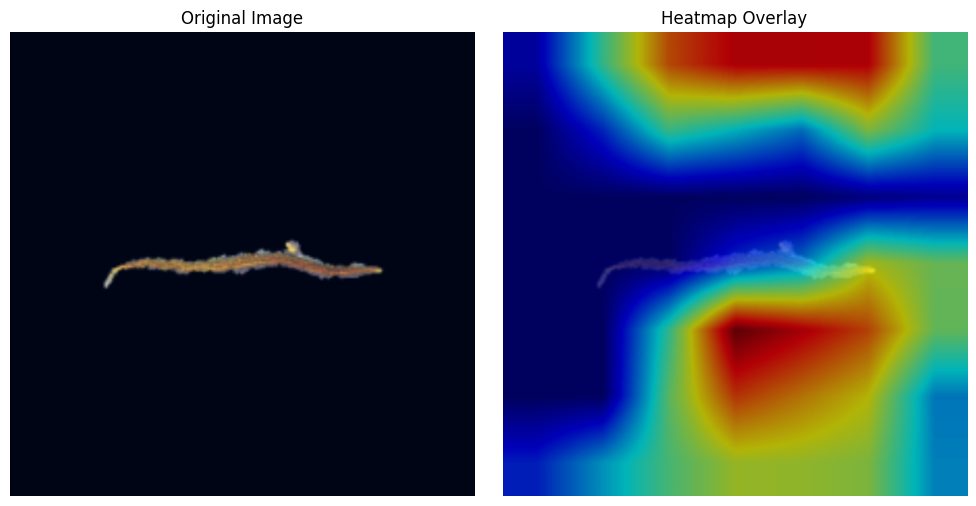

  Generating heatmap for Larvae...
  Predicted label is Larvae!


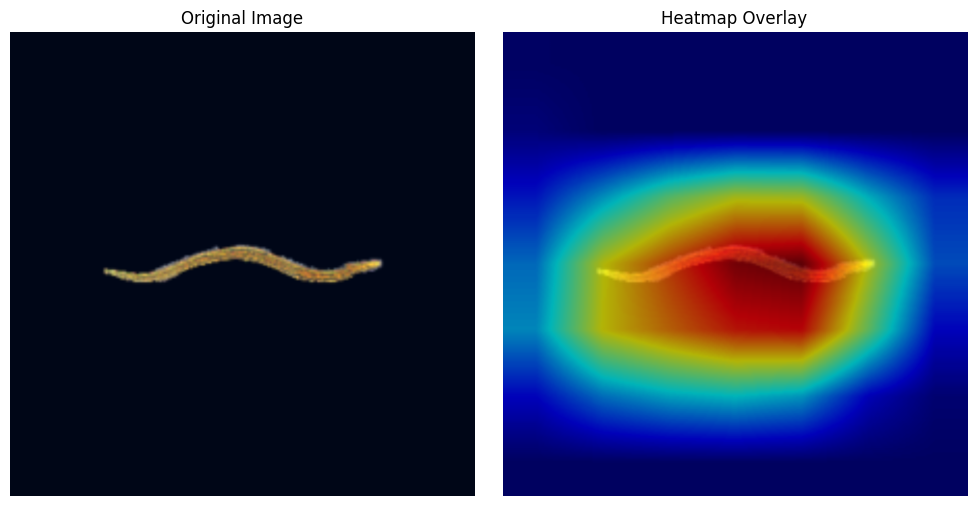

In [40]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [41]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256,512,1024],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [42]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=3e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-5)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [43]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.5763 | Val Loss: 0.6774 | Train cohen_kappa_fn: 0.0515 | Val cohen_kappa_fn: 0.0490 | Train accuracy_fn: 0.2807 | Val accuracy_fn: 0.2875
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.3499 | Val Loss: 0.4035 | Train cohen_kappa_fn: 0.7051 | Val cohen_kappa_fn: 0.7435 | Train accuracy_fn: 0.9336 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.1803 | Val Loss: 0.3004 | Train cohen_kappa_fn: 0.6439 | Val cohen_kappa_fn: 0.5888 | Train accuracy_fn: 0.8784 | Val accuracy_fn: 0.8562
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2376 | Val Loss: 0.2562 | Train cohen_kappa_fn: 0.7834 | Val cohen_kappa_fn: 0.6751 | Train accuracy_fn: 0.9336 | Val accuracy_fn: 0.8969
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.1392 | Val Loss: 0.2607 | Train cohen_kappa_fn: 0.8487 | Val cohen_kappa_fn: 0.7902 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.1537 | Val Loss: 0.2788 | Train cohen_kappa_fn: 0.5760 | Val cohen_kappa_fn: 0.5458 | Train accuracy_fn: 0.8446 | Val accuracy_fn: 0.8344
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1989 | Val Loss: 0.2881 | Train cohen_kappa_fn: 0.6798 | Val cohen_kappa_fn: 0.5812 | Train accuracy_fn: 0.8935 | Val accuracy_fn: 0.8500
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1698 | Val Loss: 0.2025 | Train cohen_kappa_fn: 0.8197 | Val cohen_kappa_fn: 0.7571 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9281
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1135 | Val Loss: 0.3888 | Train cohen_kappa_fn: 0.9169 | Val cohen_kappa_fn: 0.7570 | Train accuracy_fn: 0.9787 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0992 | Val Loss: 0.2996 | Train cohen_kappa_fn: 0.7516 | Val cohen_kappa_fn: 0.6554 | Train accuracy_fn: 0.9223 | Val accuracy_fn: 0.8906
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1407 | Val Loss: 0.3362 | Train cohen_kappa_fn: 0.8024 | Val cohen_kappa_fn: 0.6937 | Train accuracy_fn: 0.9411 | Val accuracy_fn: 0.9094
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1254 | Val Loss: 0.1981 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.8123 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1067 | Val Loss: 0.2206 | Train cohen_kappa_fn: 0.9002 | Val cohen_kappa_fn: 0.8192 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.0779 | Val Loss: 0.2695 | Train cohen_kappa_fn: 0.6815 | Val cohen_kappa_fn: 0.6804 | Train accuracy_fn: 0.8935 | Val accuracy_fn: 0.8938
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.0897 | Val Loss: 0.2087 | Train cohen_kappa_fn: 0.7596 | Val cohen_kappa_fn: 0.7305 | Train accuracy_fn: 0.9248 | Val accuracy_fn: 0.9156
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0743 | Val Loss: 0.3420 | Train cohen_kappa_fn: 0.9353 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1187 | Val Loss: 0.2243 | Train cohen_kappa_fn: 0.9313 | Val cohen_kappa_fn: 0.8313 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9563
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


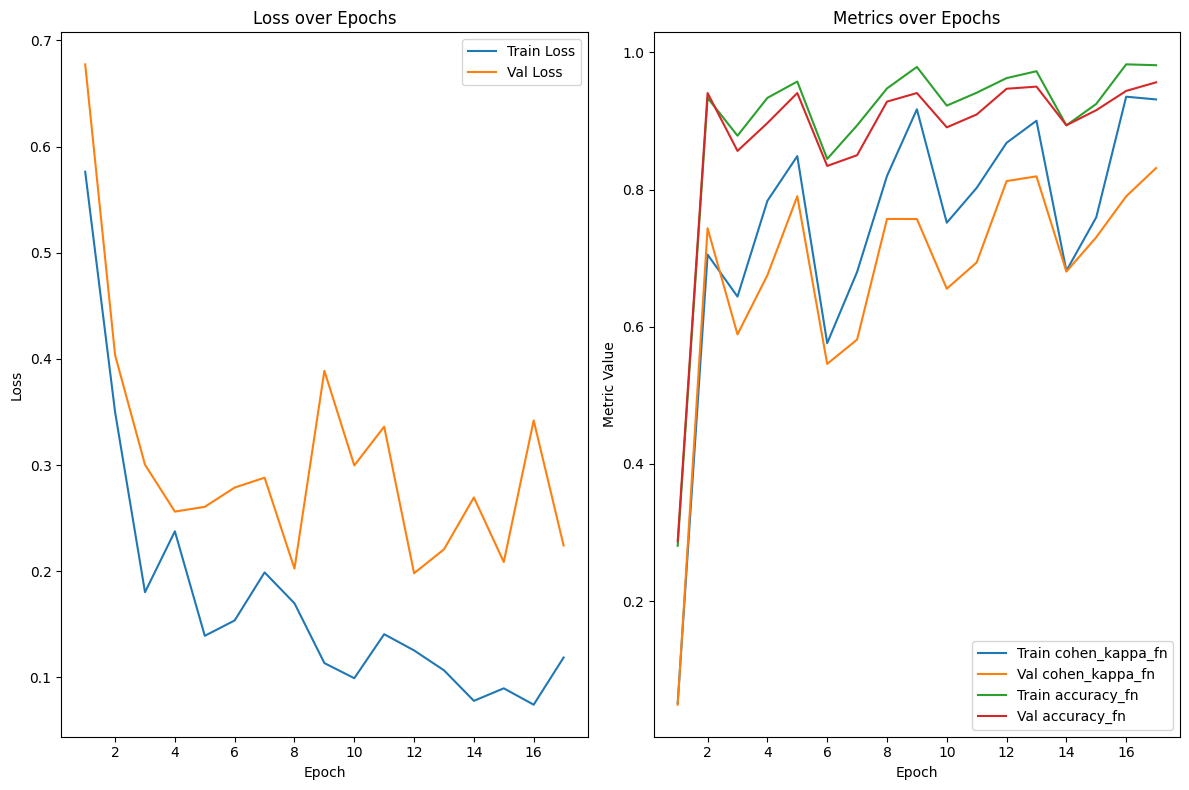

In [44]:
trainer_cnn_4.plot_epochs()

In [45]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1279 | Test cohen_kappa_fn: 0.8256 | Test accuracy_fn: 0.9500


#### Visualization

In [46]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

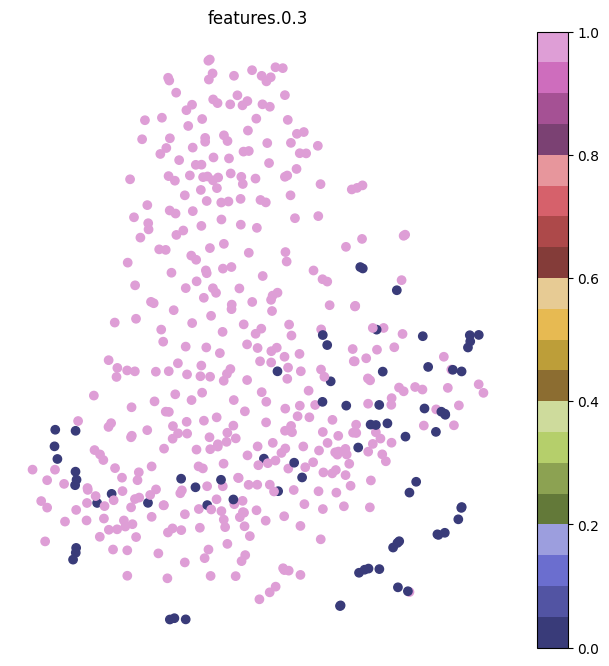

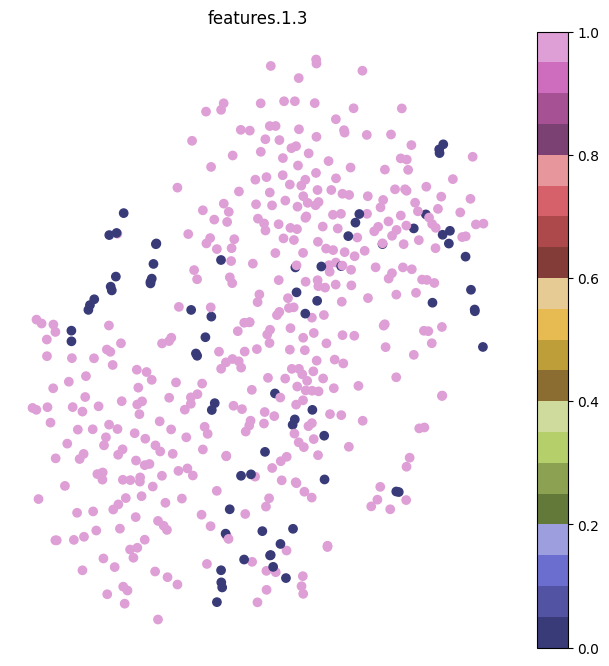

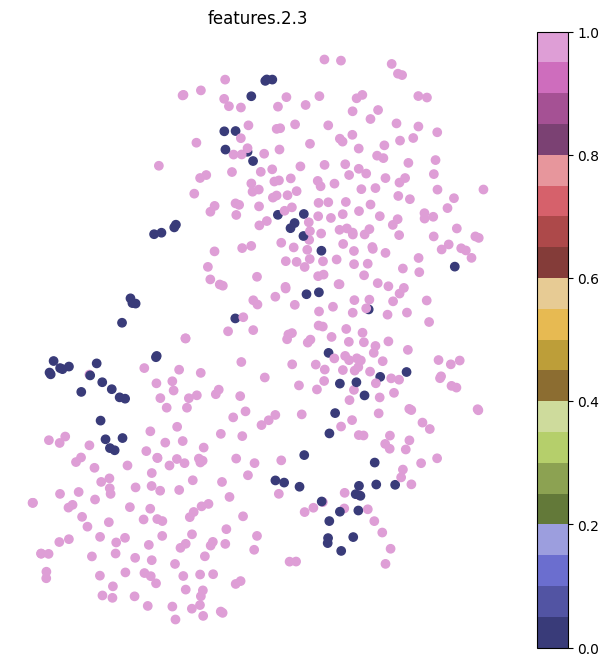

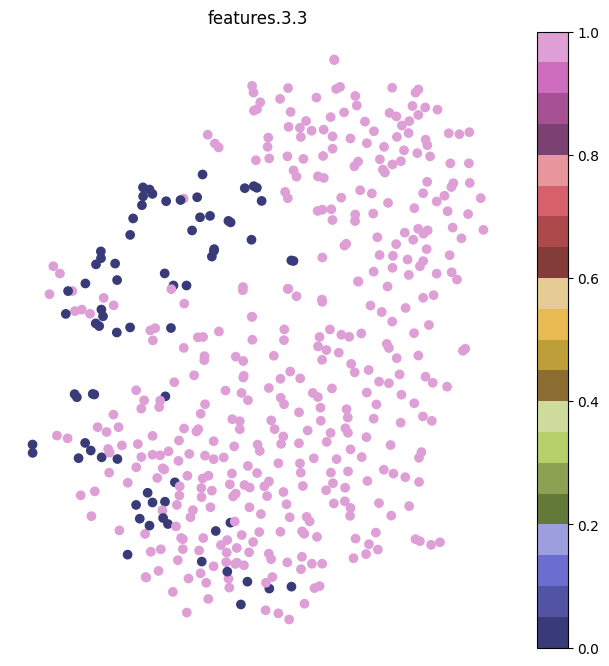

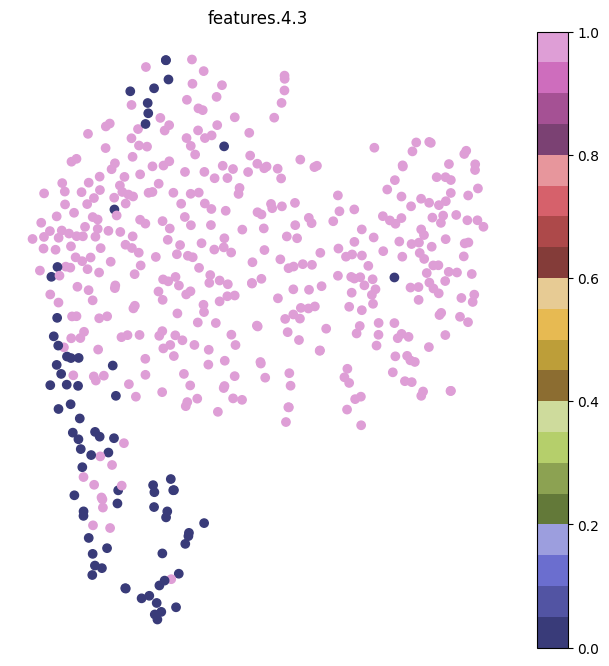

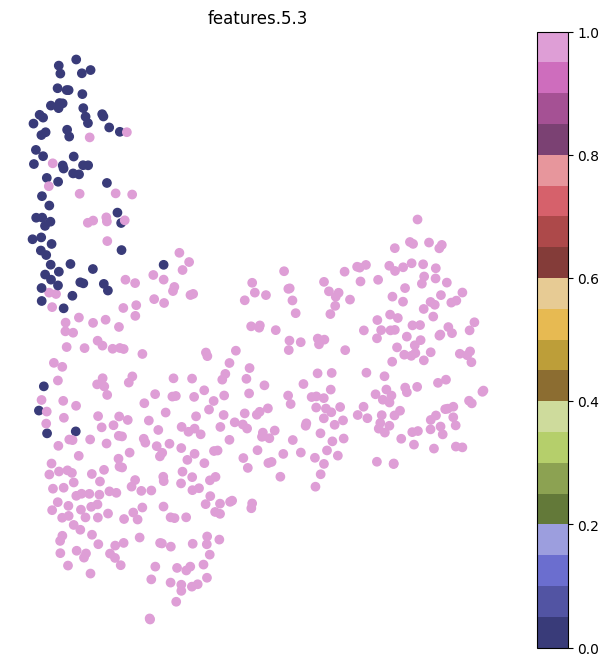

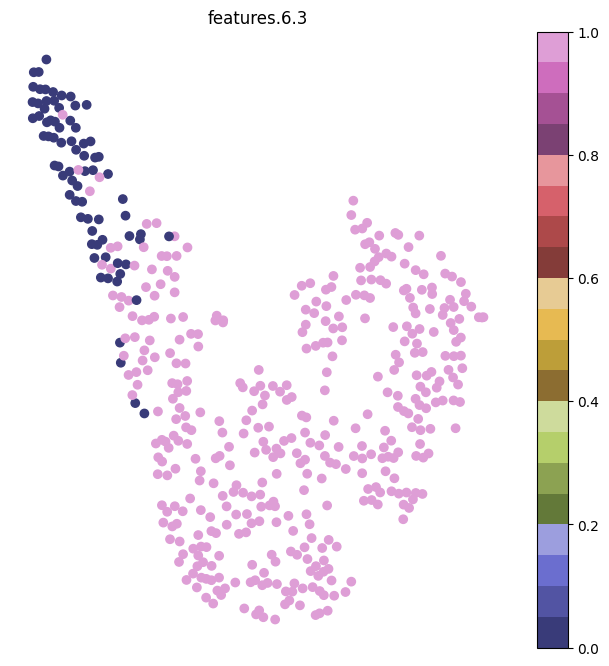

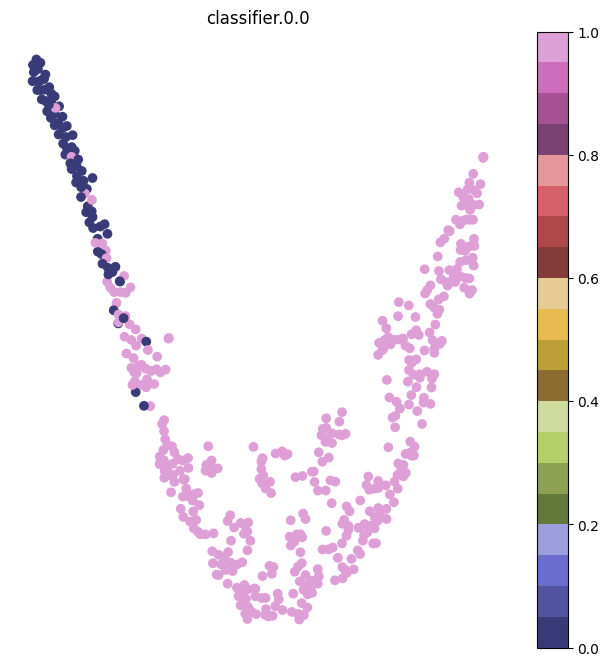

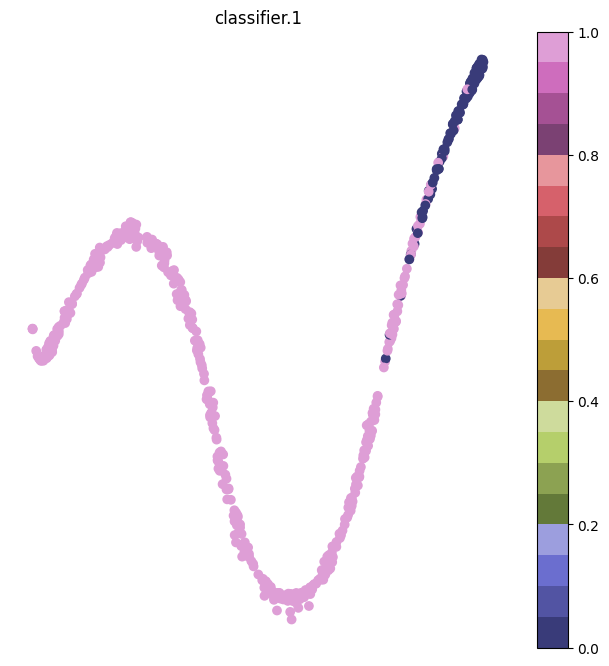

In [47]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


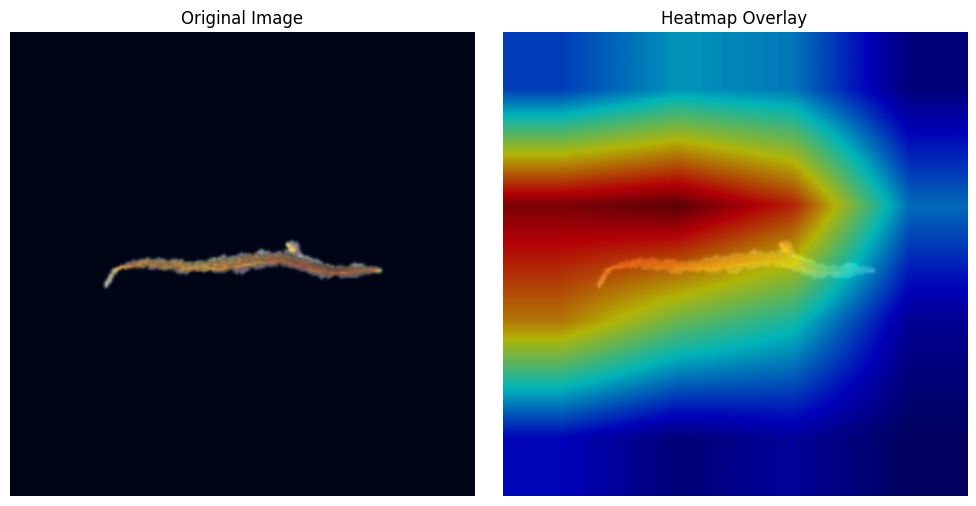

  Generating heatmap for Larvae...
  Predicted label is Larvae!


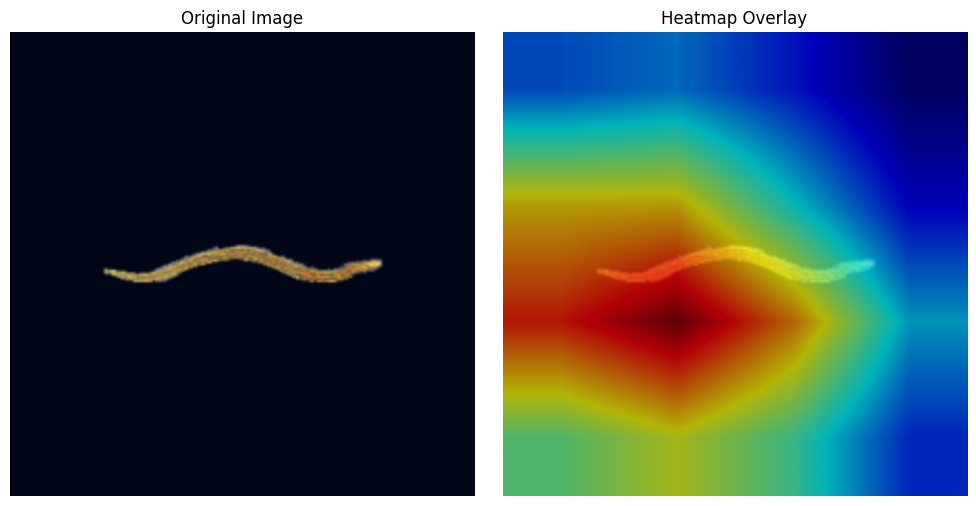

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [92]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[32,64,96,128,224],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 96, 56, 56]          55,296
      BatchNorm2d-10           [-1, 96, 56, 56]             192
             ReLU-11           [-1, 96, 56, 56]               0
        MaxPool2d-12           [-1, 96, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         110,592
      BatchNorm2d-14          [-1, 128,

In [93]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=1e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-6)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=10,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [94]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6954 | Val Loss: 0.7148 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6071 | Val Loss: 0.5672 | Train cohen_kappa_fn: 0.1454 | Val cohen_kappa_fn: 0.1650 | Train accuracy_fn: 0.4586 | Val accuracy_fn: 0.5000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.4980 | Val Loss: 0.4140 | Train cohen_kappa_fn: 0.4111 | Val cohen_kappa_fn: 0.4317 | Train accuracy_fn: 0.7581 | Val accuracy_fn: 0.7781
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4267 | Val Loss: 0.3470 | Train cohen_kappa_fn: 0.7581 | Val cohen_kappa_fn: 0.7612 | Train accuracy_fn: 0.9348 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2770 | Val Loss: 0.3027 | Train cohen_kappa_fn: 0.5212 | Val cohen_kappa_fn: 0.5289 | Train accuracy_fn: 0.8158 | Val accuracy_fn: 0.8313
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2197 | Val Loss: 0.2508 | Train cohen_kappa_fn: 0.8357 | Val cohen_kappa_fn: 0.7692 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.1780 | Val Loss: 0.2292 | Train cohen_kappa_fn: 0.8158 | Val cohen_kappa_fn: 0.7730 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1707 | Val Loss: 0.2461 | Train cohen_kappa_fn: 0.6854 | Val cohen_kappa_fn: 0.7024 | Train accuracy_fn: 0.8972 | Val accuracy_fn: 0.9094
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.1422 | Val Loss: 0.3531 | Train cohen_kappa_fn: 0.8869 | Val cohen_kappa_fn: 0.7612 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1510 | Val Loss: 1.0615 | Train cohen_kappa_fn: 0.5971 | Val cohen_kappa_fn: 0.3722 | Train accuracy_fn: 0.9173 | Val accuracy_fn: 0.8844
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1510 | Val Loss: 0.3557 | Train cohen_kappa_fn: 0.8810 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1189 | Val Loss: 0.2793 | Train cohen_kappa_fn: 0.9002 | Val cohen_kappa_fn: 0.8421 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9594
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1436 | Val Loss: 0.3127 | Train cohen_kappa_fn: 0.8791 | Val cohen_kappa_fn: 0.8313 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9563
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1234 | Val Loss: 0.2037 | Train cohen_kappa_fn: 0.7999 | Val cohen_kappa_fn: 0.7997 | Train accuracy_fn: 0.9398 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.0824 | Val Loss: 0.3211 | Train cohen_kappa_fn: 0.9152 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9774 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0906 | Val Loss: 0.3662 | Train cohen_kappa_fn: 0.9393 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9837 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.0762 | Val Loss: 0.5497 | Train cohen_kappa_fn: 0.9105 | Val cohen_kappa_fn: 0.7165 | Train accuracy_fn: 0.9774 | Val accuracy_fn: 0.9344
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1041 | Val Loss: 0.2830 | Train cohen_kappa_fn: 0.9015 | Val cohen_kappa_fn: 0.8554 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0679 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.9566 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9887 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.0589 | Val Loss: 0.4883 | Train cohen_kappa_fn: 0.9318 | Val cohen_kappa_fn: 0.7324 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.0730 | Val Loss: 0.5092 | Train cohen_kappa_fn: 0.9360 | Val cohen_kappa_fn: 0.7324 | Train accuracy_fn: 0.9837 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0601 | Val Loss: 0.2993 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.8554 | Train accuracy_fn: 0.9799 | Val accuracy_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.0813 | Val Loss: 0.3034 | Train cohen_kappa_fn: 0.4607 | Val cohen_kappa_fn: 0.5801 | Train accuracy_fn: 0.7757 | Val accuracy_fn: 0.8469
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.0592 | Val Loss: 0.2940 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9799 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


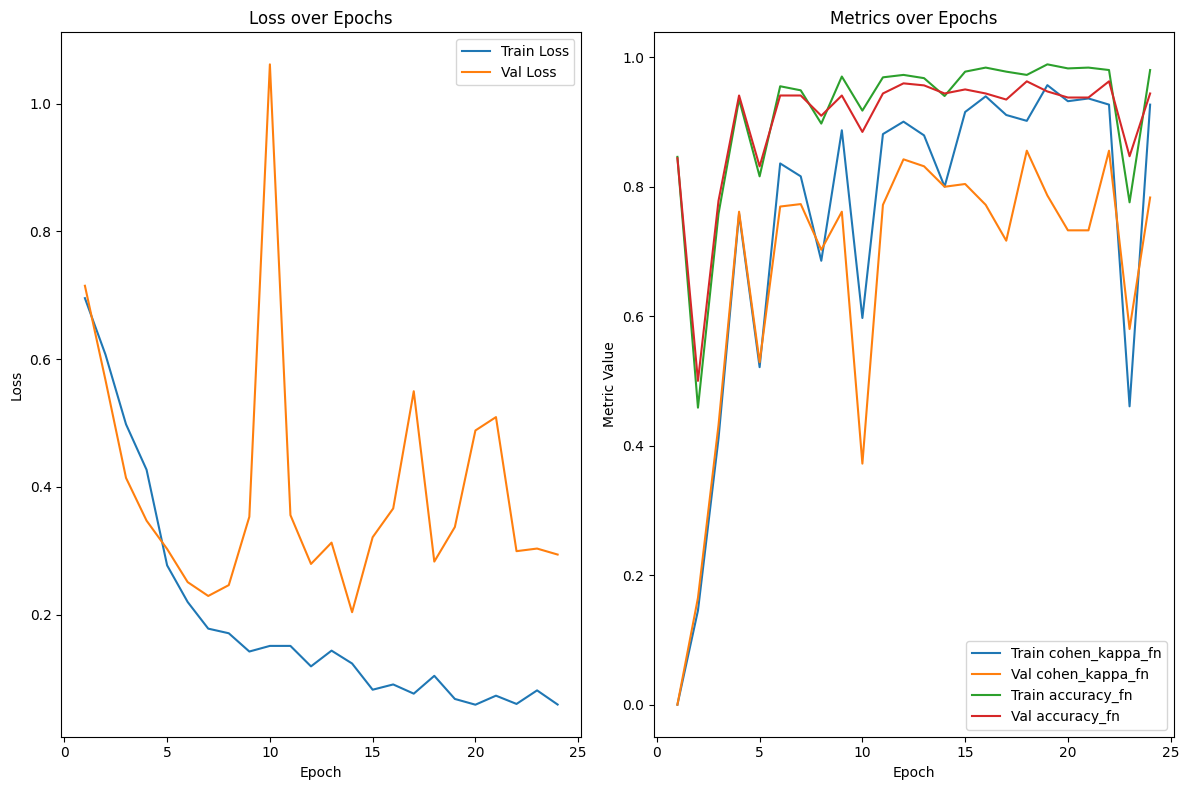

In [95]:
trainer_cnn_5.plot_epochs()

In [85]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1847 | Test cohen_kappa_fn: 0.8313 | Test accuracy_fn: 0.9563


#### Visualization

In [54]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

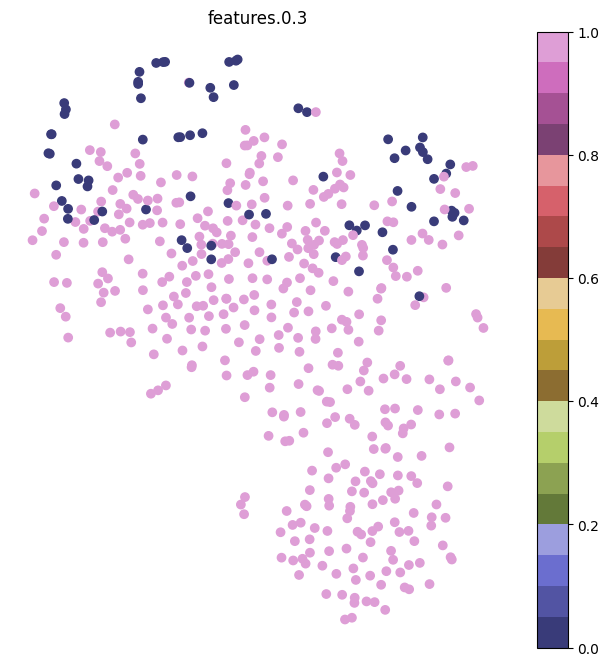

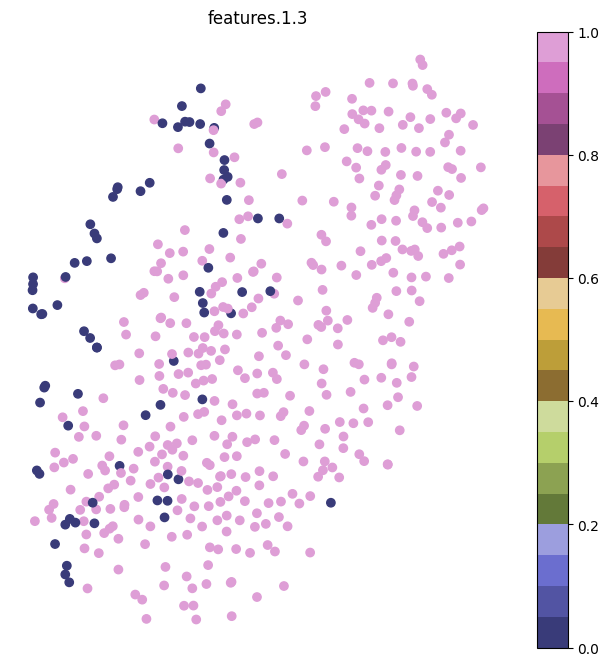

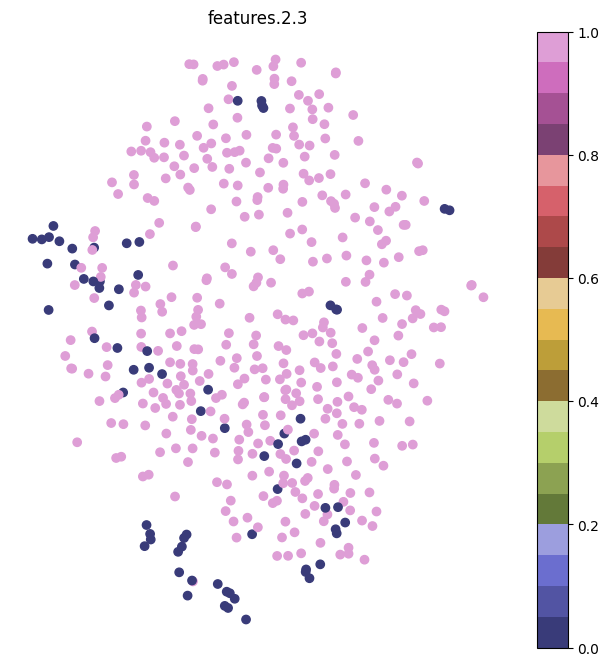

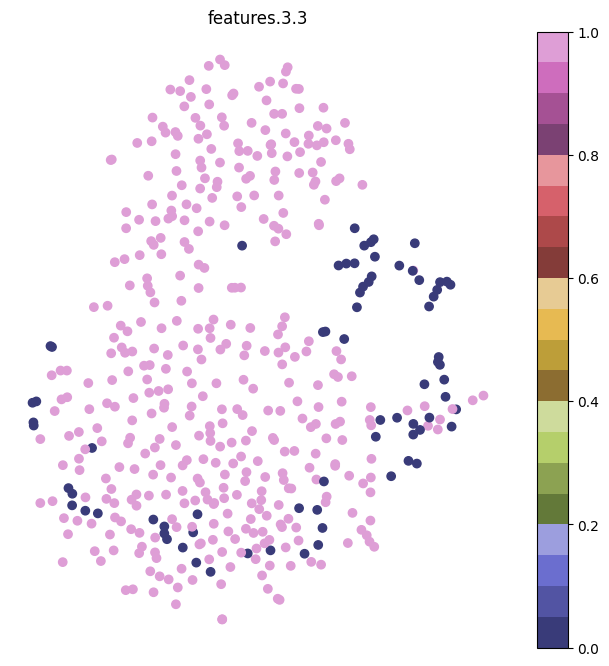

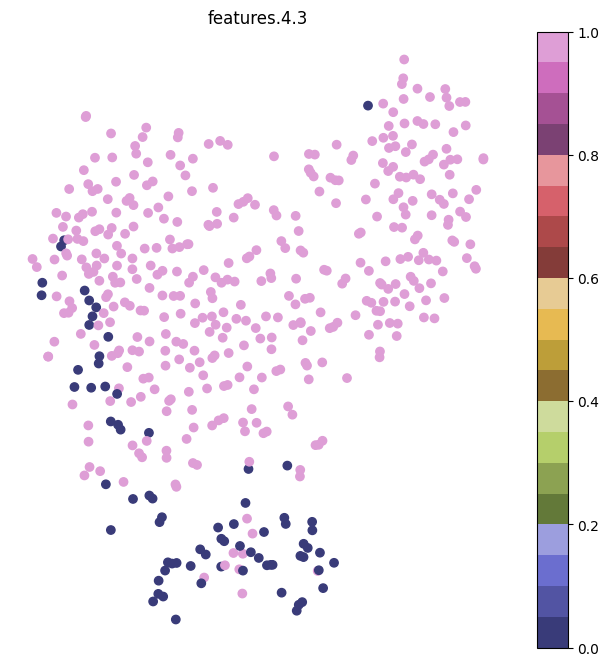

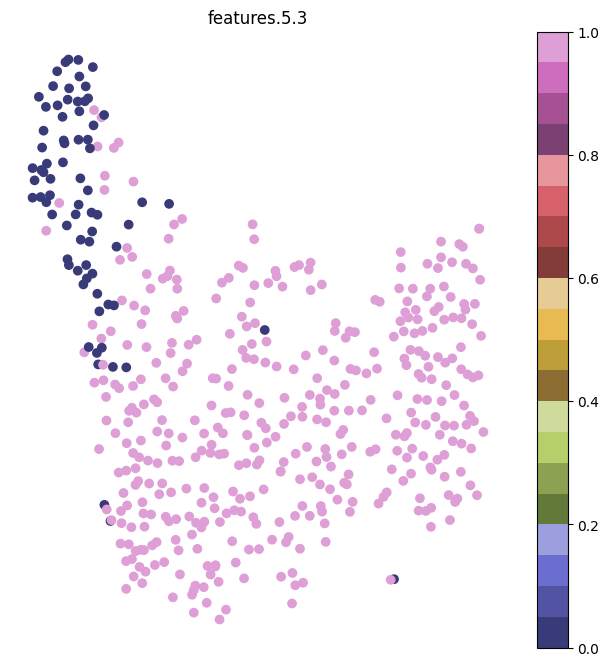

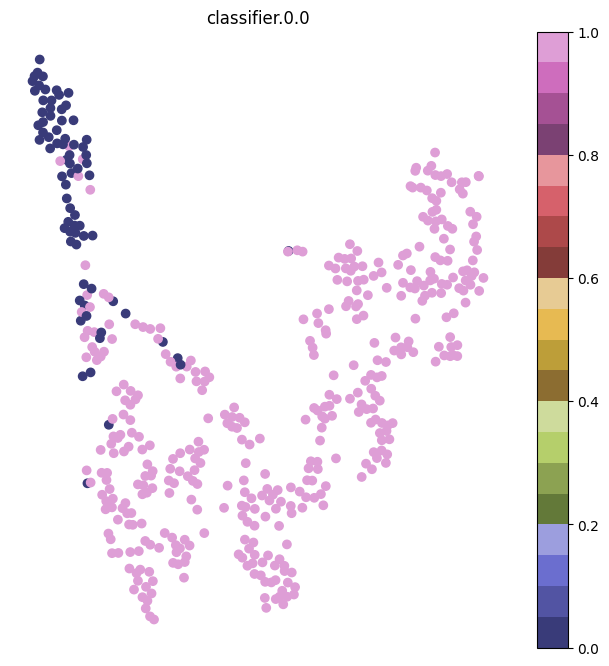

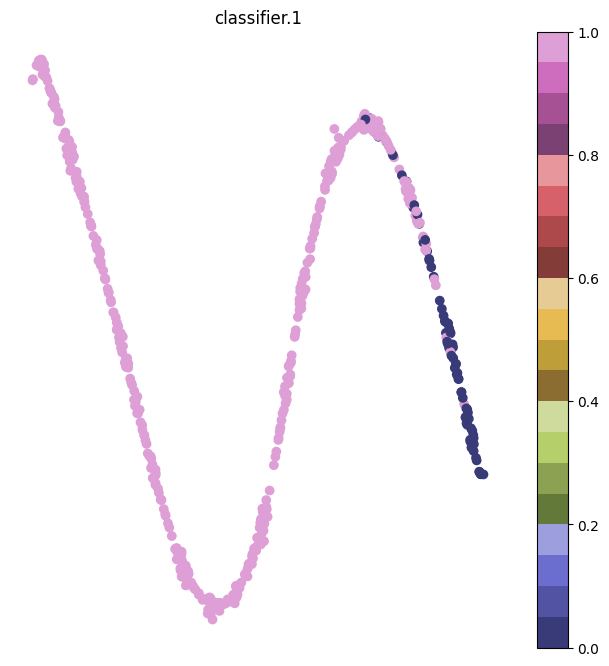

In [55]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


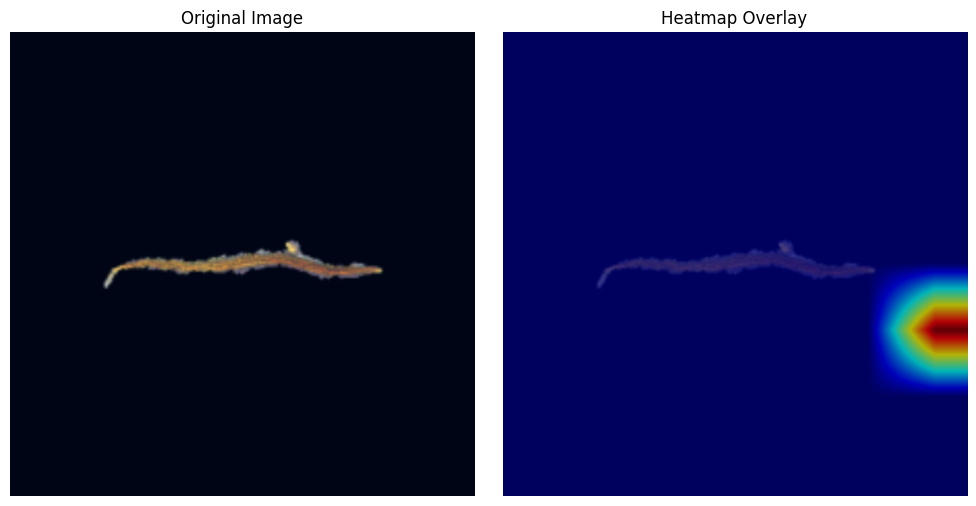

  Generating heatmap for Larvae...
  Predicted label is Larvae!


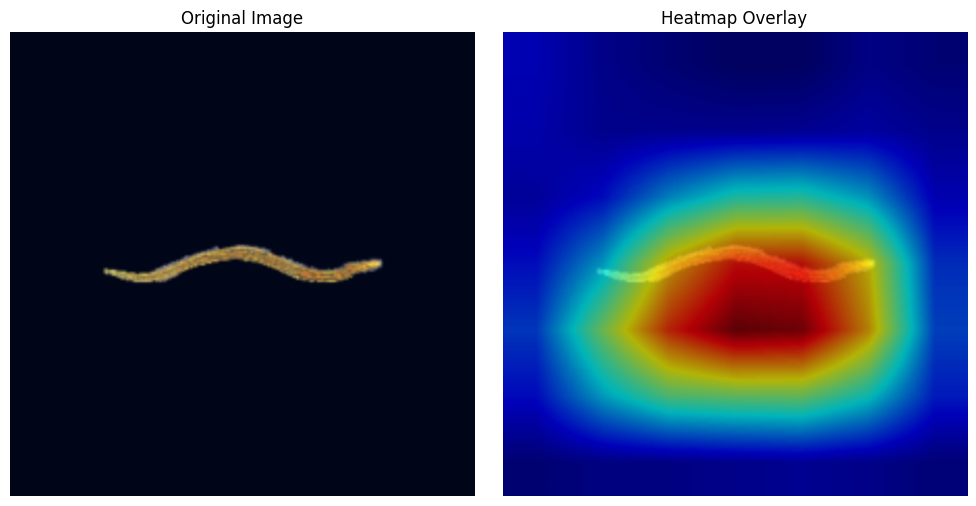

In [56]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [57]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,64,96,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [58]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=3e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-5)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [59]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6620 | Val Loss: 0.5869 | Train cohen_kappa_fn: 0.3627 | Val cohen_kappa_fn: 0.3182 | Train accuracy_fn: 0.7581 | Val accuracy_fn: 0.6781
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4721 | Val Loss: 0.5544 | Train cohen_kappa_fn: 0.3116 | Val cohen_kappa_fn: 0.1413 | Train accuracy_fn: 0.6642 | Val accuracy_fn: 0.4563
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2839 | Val Loss: 0.3133 | Train cohen_kappa_fn: 0.6968 | Val cohen_kappa_fn: 0.7405 | Train accuracy_fn: 0.9286 | Val accuracy_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2938 | Val Loss: 0.3732 | Train cohen_kappa_fn: 0.5125 | Val cohen_kappa_fn: 0.4132 | Train accuracy_fn: 0.8133 | Val accuracy_fn: 0.7406
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2113 | Val Loss: 0.5585 | Train cohen_kappa_fn: 0.5875 | Val cohen_kappa_fn: 0.6245 | Train accuracy_fn: 0.9135 | Val accuracy_fn: 0.9187
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.2075 | Val Loss: 0.5275 | Train cohen_kappa_fn: 0.3877 | Val cohen_kappa_fn: 0.2936 | Train accuracy_fn: 0.7231 | Val accuracy_fn: 0.6438
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1711 | Val Loss: 1.3990 | Train cohen_kappa_fn: 0.3327 | Val cohen_kappa_fn: 0.2703 | Train accuracy_fn: 0.8810 | Val accuracy_fn: 0.8719
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2054 | Val Loss: 0.5489 | Train cohen_kappa_fn: 0.3340 | Val cohen_kappa_fn: 0.2690 | Train accuracy_fn: 0.6779 | Val accuracy_fn: 0.6125
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


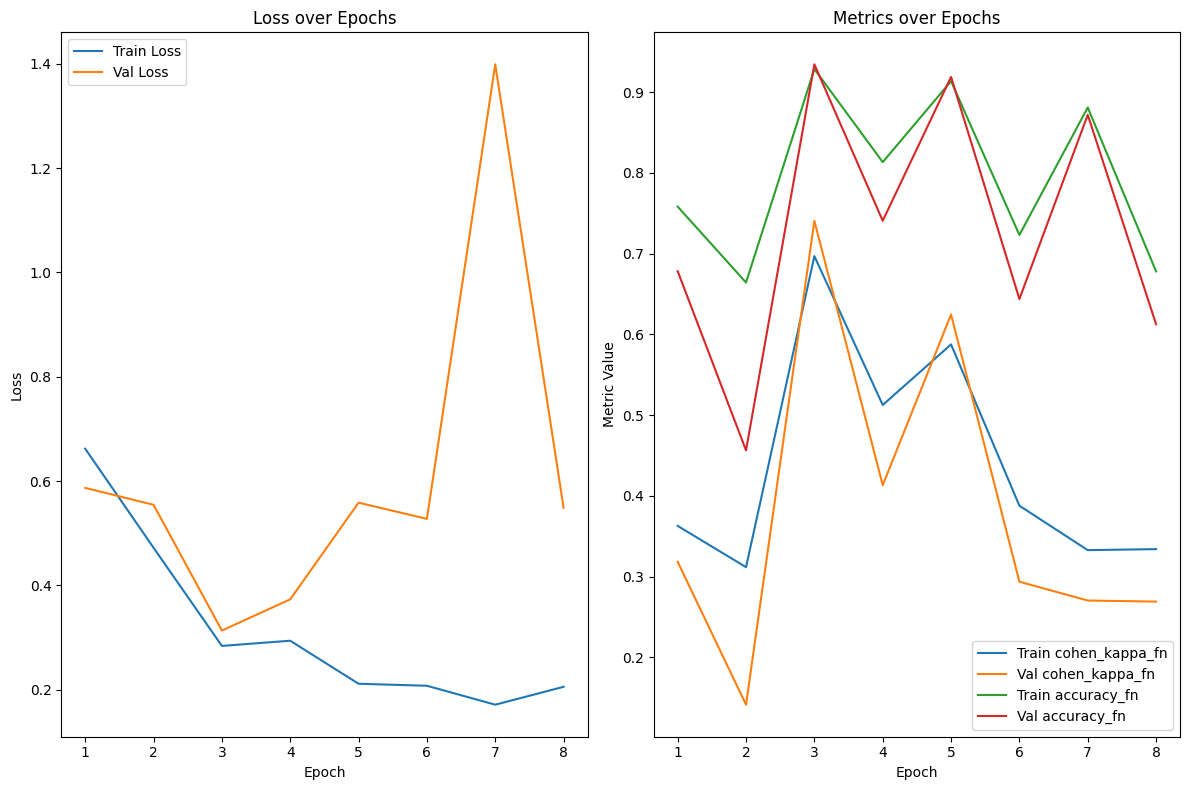

In [60]:
trainer_cnn_6.plot_epochs()

In [61]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3506 | Test cohen_kappa_fn: 0.7126 | Test accuracy_fn: 0.9312


#### Visualization

In [62]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

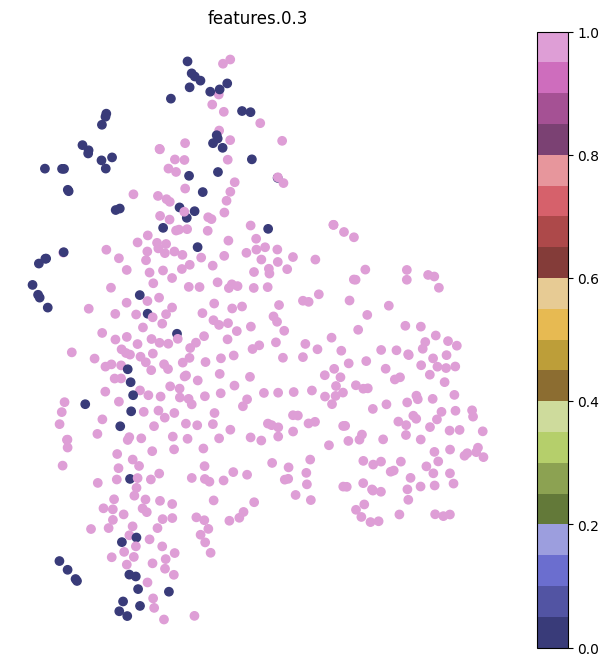

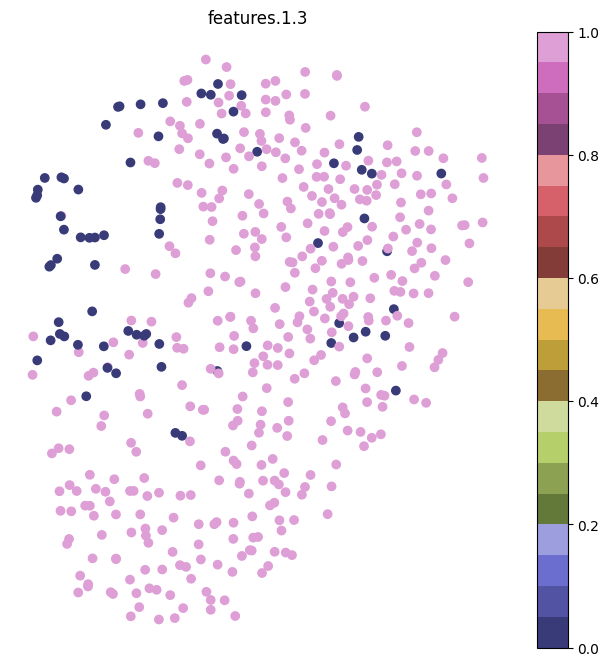

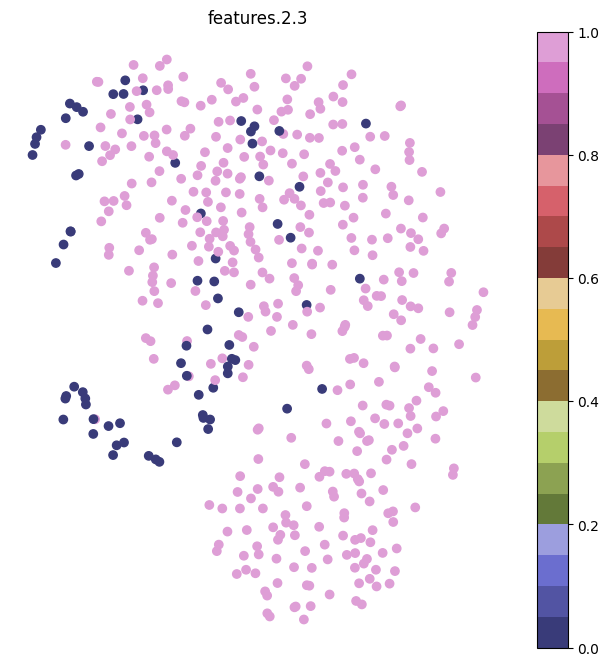

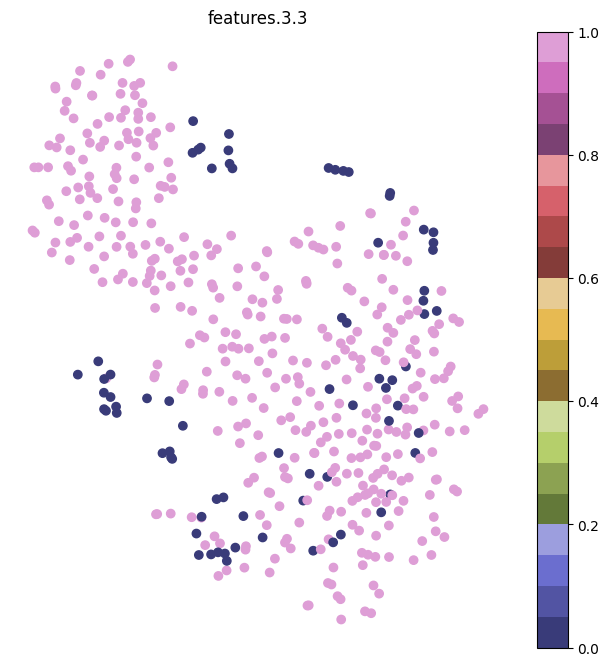

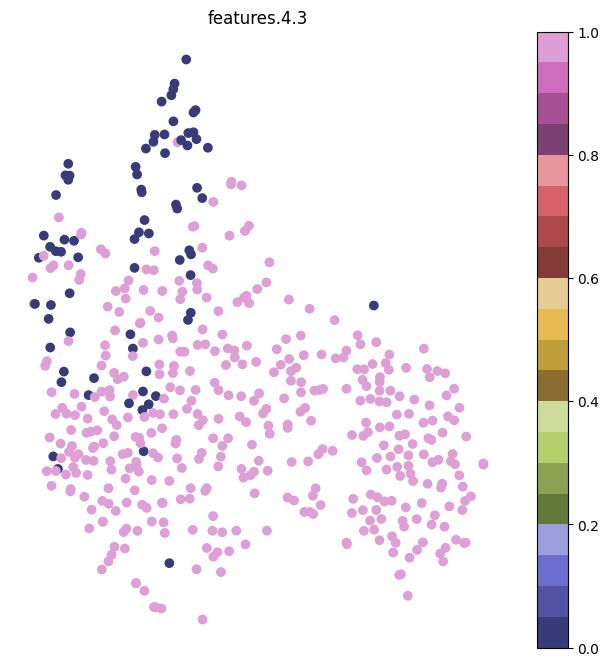

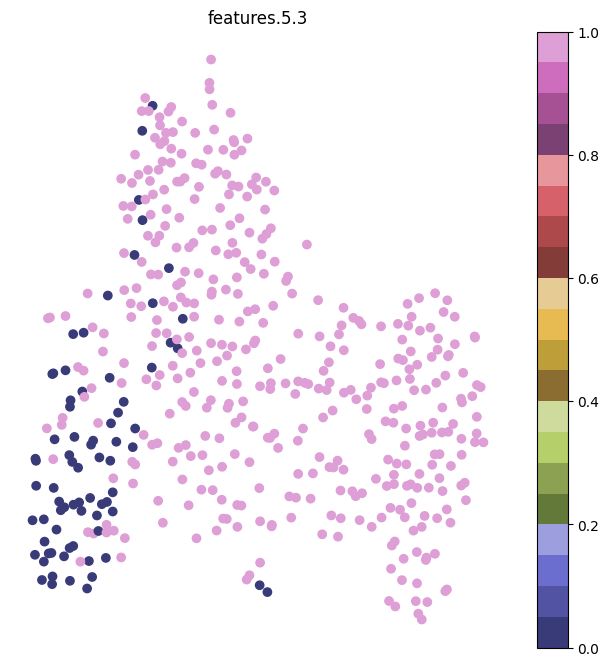

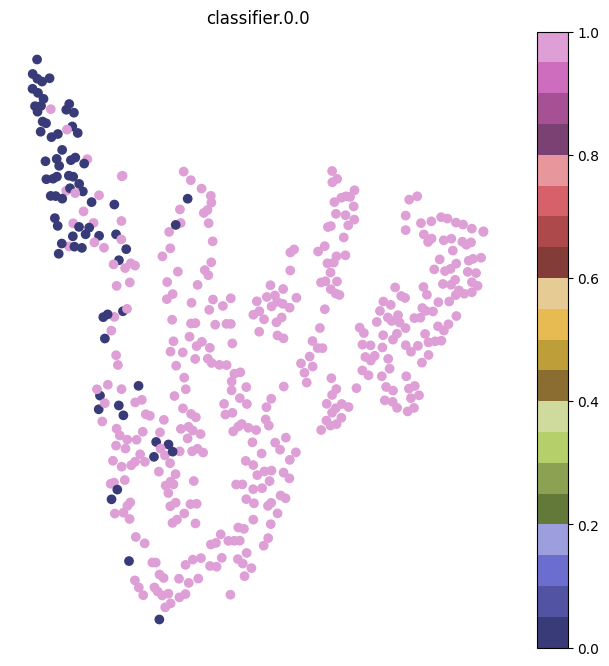

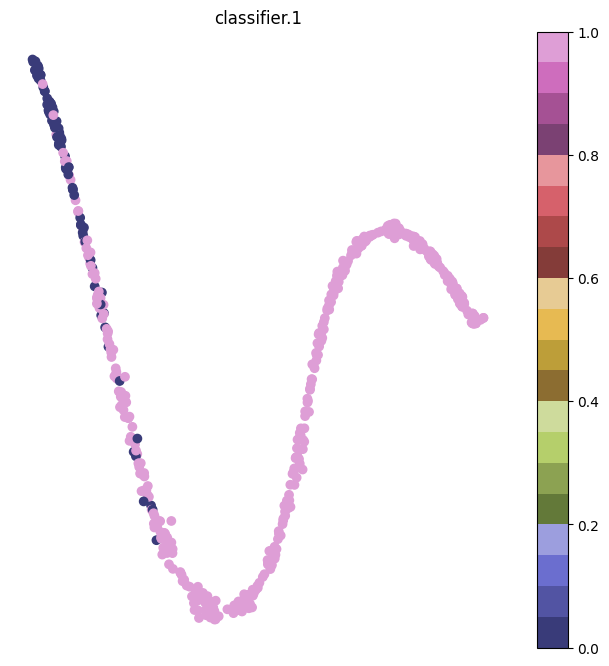

In [63]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


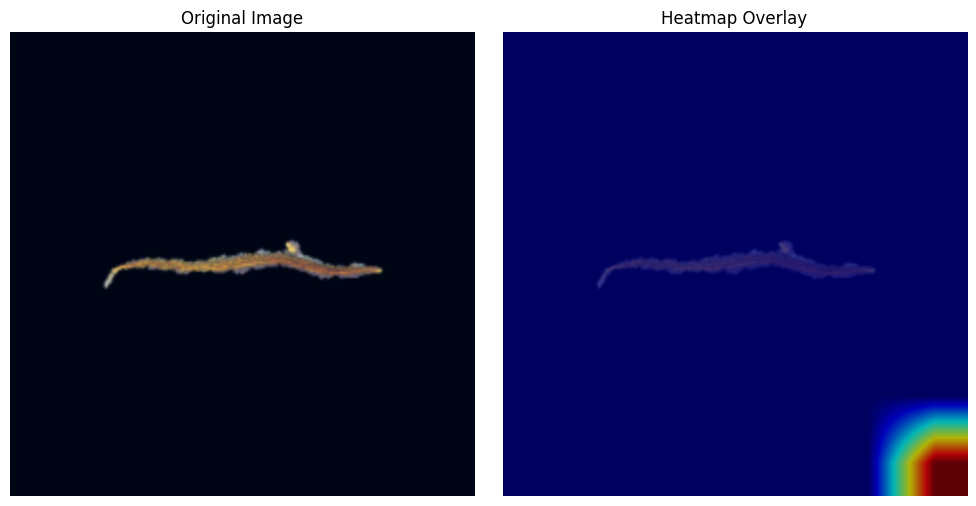

  Generating heatmap for Larvae...
  Predicted label is Larvae!


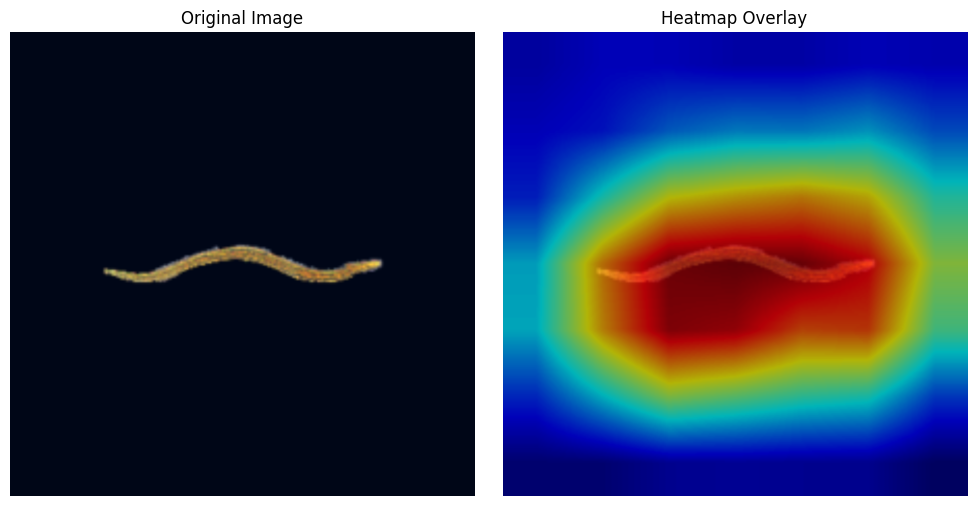

In [64]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [65]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96,128,224],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [66]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=3e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-5)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [67]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6590 | Val Loss: 0.6012 | Train cohen_kappa_fn: 0.1344 | Val cohen_kappa_fn: 0.1106 | Train accuracy_fn: 0.4561 | Val accuracy_fn: 0.4062
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4331 | Val Loss: 0.7520 | Train cohen_kappa_fn: 0.1562 | Val cohen_kappa_fn: 0.0740 | Train accuracy_fn: 0.4749 | Val accuracy_fn: 0.3281
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.2611 | Val Loss: 0.3184 | Train cohen_kappa_fn: 0.6477 | Val cohen_kappa_fn: 0.5230 | Train accuracy_fn: 0.8810 | Val accuracy_fn: 0.8281
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2537 | Val Loss: 0.3971 | Train cohen_kappa_fn: 0.6963 | Val cohen_kappa_fn: 0.7373 | Train accuracy_fn: 0.9311 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2264 | Val Loss: 0.4589 | Train cohen_kappa_fn: 0.3697 | Val cohen_kappa_fn: 0.3208 | Train accuracy_fn: 0.7105 | Val accuracy_fn: 0.6750
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.1519 | Val Loss: 0.3531 | Train cohen_kappa_fn: 0.8823 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1565 | Val Loss: 0.3584 | Train cohen_kappa_fn: 0.8914 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1513 | Val Loss: 0.2140 | Train cohen_kappa_fn: 0.8970 | Val cohen_kappa_fn: 0.7234 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9187
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1189 | Val Loss: 0.3177 | Train cohen_kappa_fn: 0.6503 | Val cohen_kappa_fn: 0.5335 | Train accuracy_fn: 0.8797 | Val accuracy_fn: 0.8219
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0969 | Val Loss: 1.0156 | Train cohen_kappa_fn: 0.6247 | Val cohen_kappa_fn: 0.4870 | Train accuracy_fn: 0.9223 | Val accuracy_fn: 0.9000
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1160 | Val Loss: 0.3388 | Train cohen_kappa_fn: 0.6078 | Val cohen_kappa_fn: 0.5505 | Train accuracy_fn: 0.8596 | Val accuracy_fn: 0.8313
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1214 | Val Loss: 0.2574 | Train cohen_kappa_fn: 0.7288 | Val cohen_kappa_fn: 0.5987 | Train accuracy_fn: 0.9135 | Val accuracy_fn: 0.8562
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1011 | Val Loss: 0.5862 | Train cohen_kappa_fn: 0.8018 | Val cohen_kappa_fn: 0.7386 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


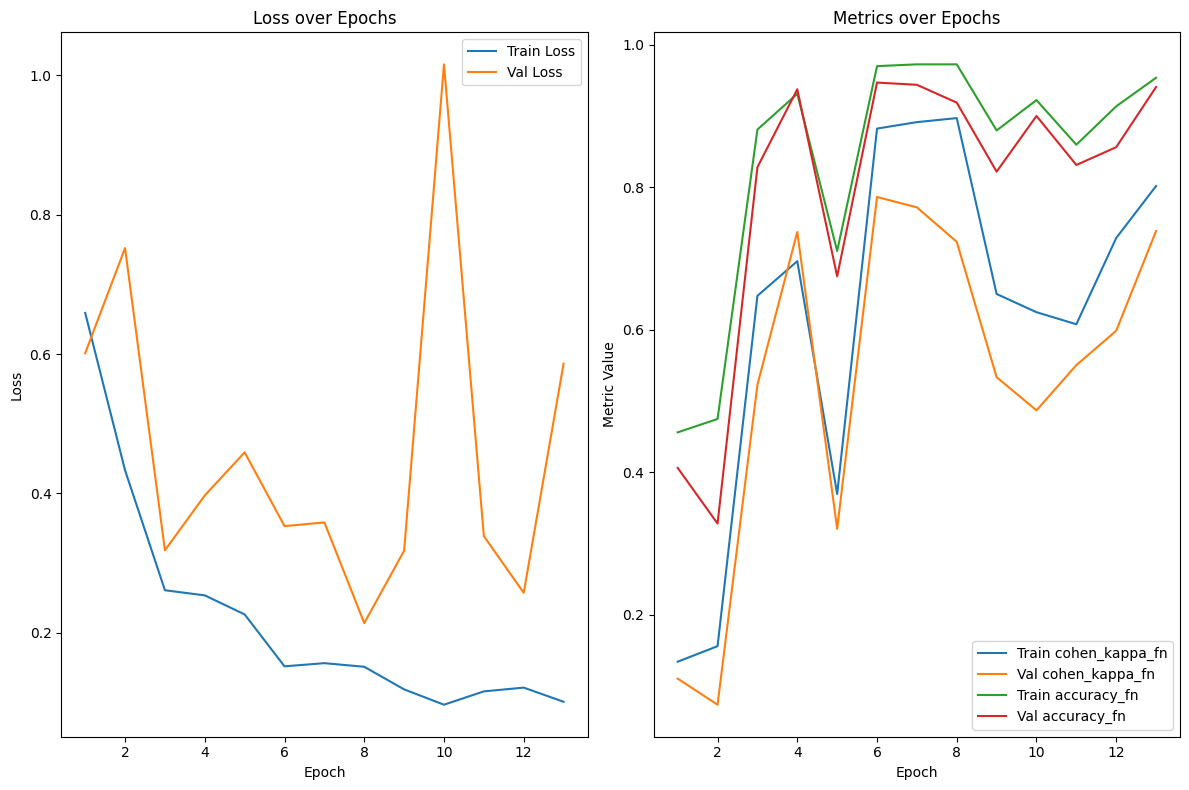

In [68]:
trainer_cnn_7.plot_epochs()

In [69]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1732 | Test cohen_kappa_fn: 0.8052 | Test accuracy_fn: 0.9458


#### Visualization

In [70]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

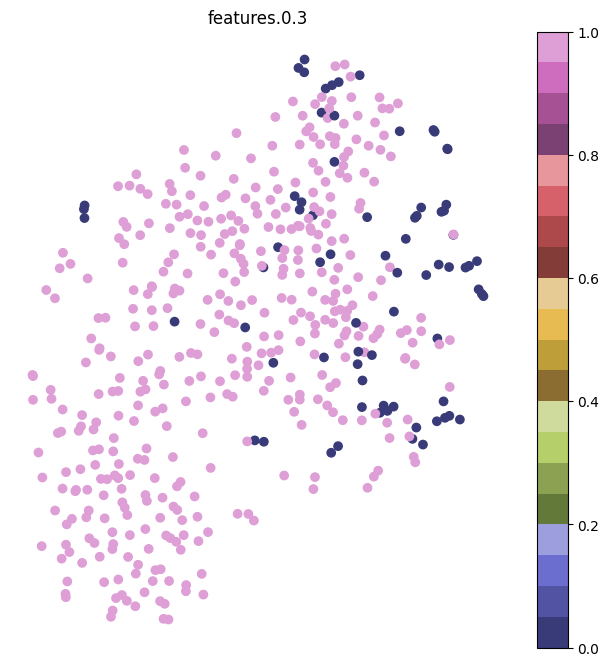

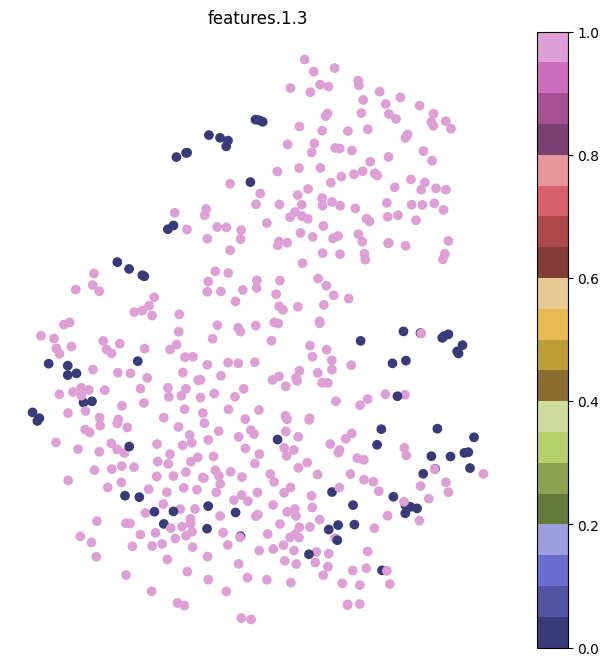

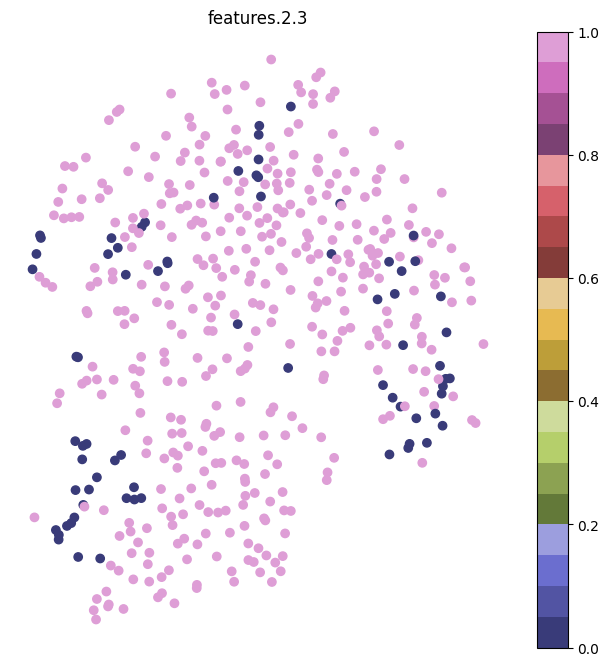

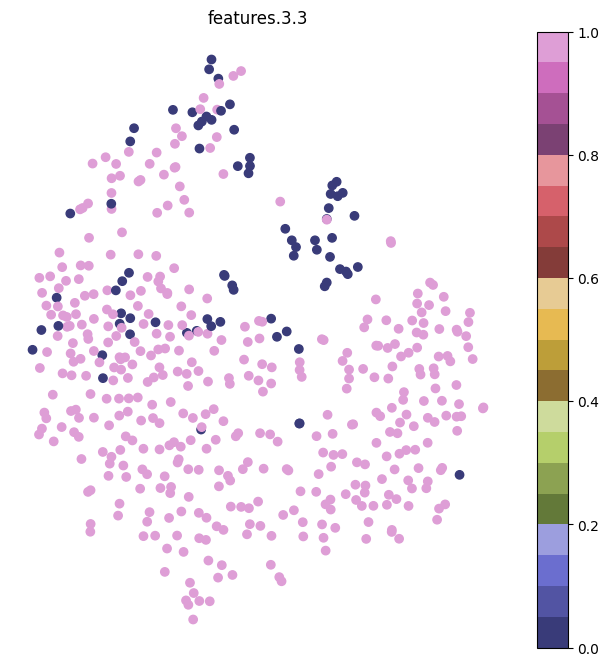

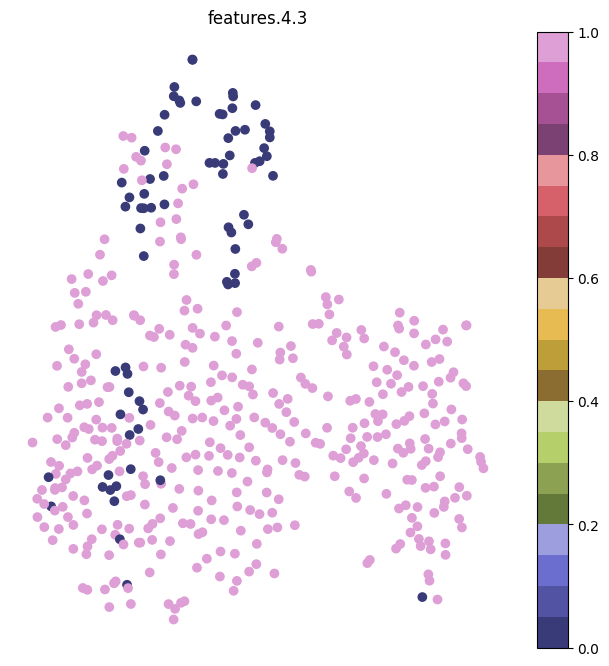

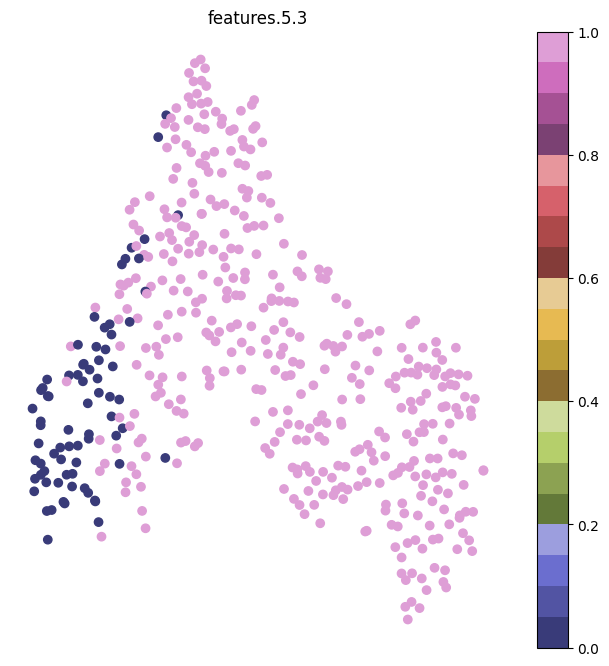

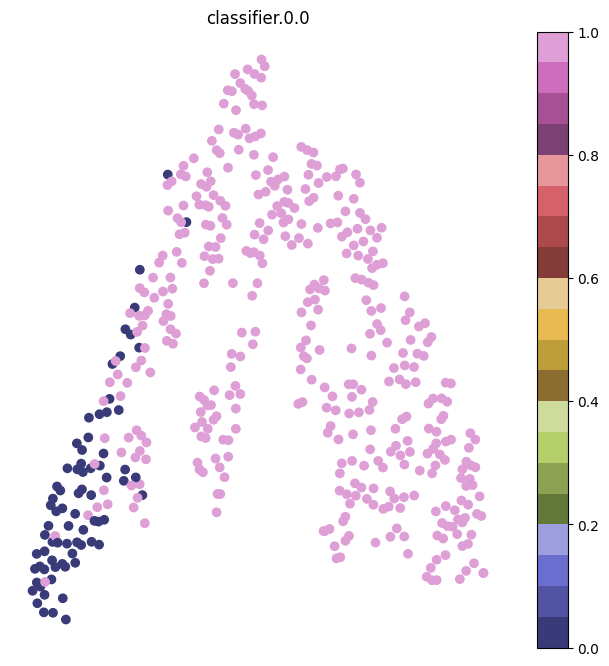

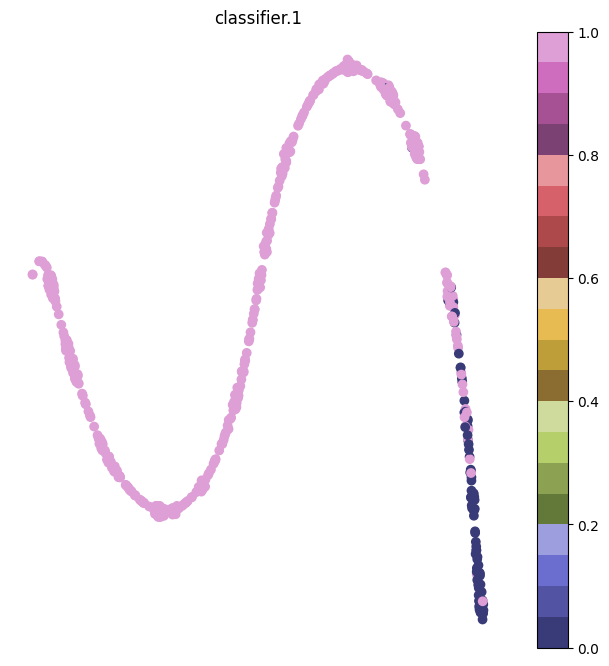

In [71]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


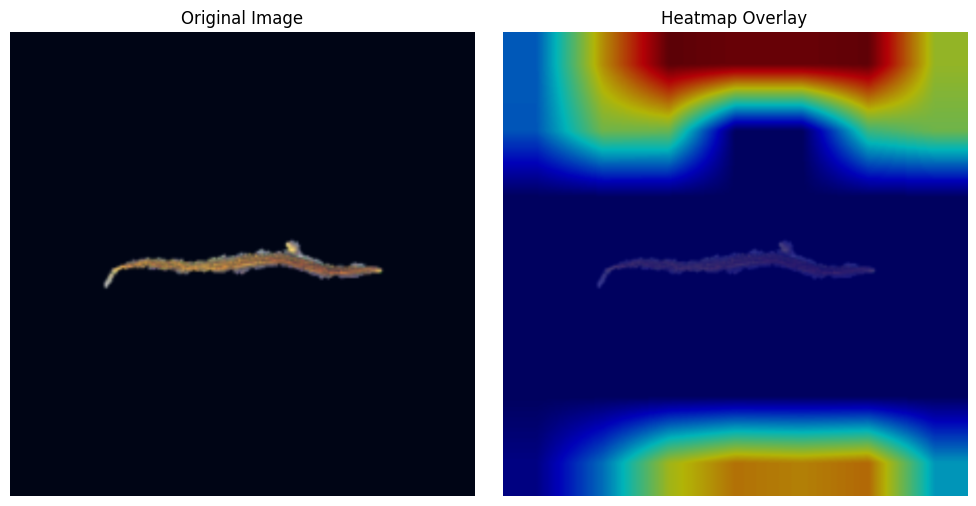

  Generating heatmap for Larvae...
  Predicted label is Larvae!


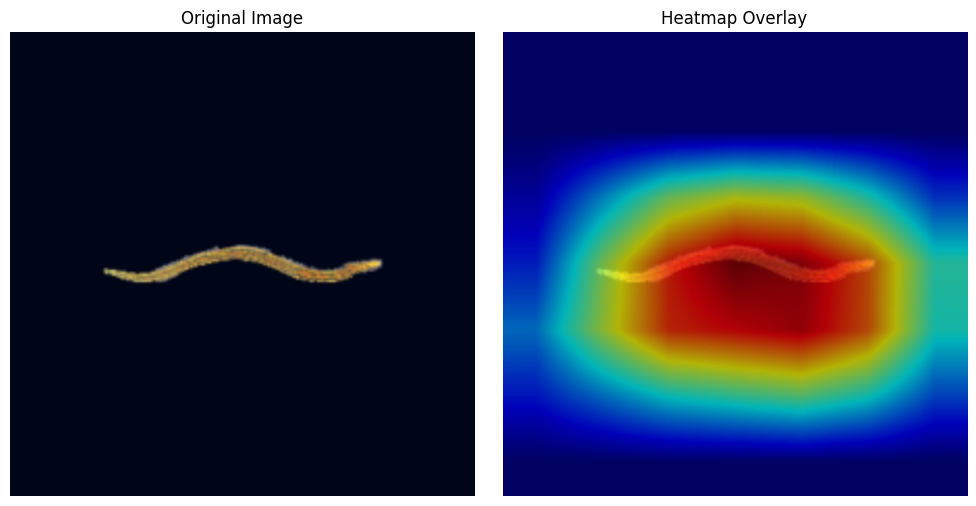

In [72]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break